# Imports and Setup

Download https://www.kaggle.com/datasets/Cornell-University/arxiv and put the .json into the same folder as this file before running.

In [6]:
!pip install -U bertopic sentence-transformers
!pip install tf-keras
from bertopic import BERTopic


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 1.7/1.7 MB 13.7 MB/s eta 0:00:00



In [3]:
# 2 min 30 sec to execute

!pip install -U bertopic sentence-transformers
# from google.colab import files

import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import seaborn as sns

     -------------------------------------- 340.6/340.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 4.0.1
    Uninstalling sentence-transformers-4.0.1:
      Successfully uninstalled sentence-transformers-4.0.1



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


RuntimeError: Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
# Junk Topic Imports

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Google Drive Imports

from google.colab import drive
drive.mount('/content/drive')

# This reads the paths for the files we saved and put in google Drive

embeddings_path = '/content/drive/MyDrive/Colab Notebooks/embeddings.npy'
# model_path = '/content/drive/MyDrive/Colab Notebooks/bertopic_model.bin'
model_path = 'bertopic_model.bin'

results_path = '/content/drive/MyDrive/Colab Notebooks/topic_results.csv'

Mounted at /content/drive


# Section 1: Preprocessing

In [1]:
model_path = 'bertopic_model.bin'

In [ ]:
# Read data from JSON file then filter it and save to filtered_data.csv

file_path = "arxiv-metadata-oai-snapshot.json"

# Filter by STEM prefixes to cut down dataset to a manageable subset

valid_prefixes = ['cs.', 'math.', 'stat.', 'physics.comp-']

# Initialize storage
filtered_data = []

# Read and filter
with open(file_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading and filtering JSON"):
        try:
            record = json.loads(line)
            primary_cat = record.get("categories", "").split()[0]
            if any(primary_cat.startswith(prefix) for prefix in valid_prefixes):
                filtered_data.append({
                    "id": record.get("id"),
                    "title": record.get("title", "").strip(),
                    "abstract": record.get("abstract", "").strip(),
                    "categories": record.get("categories"),
                    "authors": record.get("authors_parsed"),
                    "date": record.get("update_date", "")[:10]  # YYYY-MM-DD
                })
        except json.JSONDecodeError:
            continue

# Convert to DataFrame
df = pd.DataFrame(filtered_data)
df.to_csv("filtered_data.csv", index=False)
print("Filtered Data Shape:", df.shape)
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'arxiv-metadata-oai-snapshot.json'

In [ ]:
# Read filtered data csv and cleans corrupted rows

try:
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/filtered_data.csv", on_bad_lines='skip', engine="python")
    print(f"Loaded Data Shape: {df.shape}")
    df.head()
except pd.errors.ParserError as e:
    print(f"ParserError encountered: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Loaded Data Shape: (938045, 6)


In [ ]:
df.shape

(938045, 6)

After narrowing our dataset to only Computer Science, Stats, Physics, and Stats papers, we were at a 938k dataset. Our BERT model could not run properly with the computational power that we had, even using T4 GPUs on Google Colab. So we looked to see how many papers exist in each topic

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.head()

id                                              title  \
1040  705.0167  A duality between pairs of split decomposition...   
1352  705.1282  Design of a Three-Axis Isotropic Parallel Mani...   
622   704.2629                    Families of holomorphic bundles   
623   704.2631      The E-theoretic descent functor for groupoids   
1351  705.1280  A Novel method for the design of 2-DOF Paralle...   

                                               abstract  \
1040  Let $\Gamma$ denote a $Q$-polynomial distance-...   
1352  The orthoglide is a 3-DOF parallel mechanism d...   
622   The first goal of the article is to solve seve...   
623   The paper establishes, for a wide class of loc...   
1351  Parallel Kinematic Mechanisms (PKM) are intere...   

                   categories  \
1040                  math.CO   
1352                    cs.RO   
622   math.DG math.AG math.CV   
623           math.OA math.KT   
1351                    cs.RO   

                                                authors       date  
1040                          [['Kim', 'Joohyung', '']] 2007-05-23  
1352  [['Wenger', 'Philippe', '', 'IRCCyN'], ['Chabl... 2007-05-23  
622                         [['Teleman', 'Andrei', '']] 2007-05-23  
623                    [['Paterson', 'Alan L. T.', '']] 2007-05-23  
1351  [['Majou', 'Félix', '', 'IRCCyN'], ['Wenger', ... 2007-05-23

In [ ]:
df.tail()

id                                              title  \
574696  2007.09778  Normal Reflection Subgroups of Complex Reflect...   
571148  2007.03340  Safety Controller Synthesis for Collaborative ...   
870412  2305.16783  The concept of mapped coercivity for nonlinear...   
316590  1703.03297     A lower bound for Heilbronn's triangle-problem   
926322  2311.01126  Two improved algorithms for sparse generalized...   

                                                 abstract  \
574696  We study normal reflection subgroups of comple...   
571148  In human-robot collaboration (HRC), software-b...   
870412  We provide a concise proof of existence for no...   
316590  Let n points be placed on a closed convex doma...   
926322  Regularized generalized canonical correlation ...   

                 categories  \
574696      math.CO math.RT   
571148  cs.RO cs.SY eess.SY   
870412      math.AP math.FA   
316590      math.MG math.NT   
926322      math.ST stat.TH   

                                                  authors       date  
574696  [['Arreche', 'Carlos E.', ''], ['Williams', 'N... 2025-03-21  
571148  [['Gleirscher', 'Mario', ''], ['Calinescu', 'R... 2025-03-21  
870412  [['Becker', 'Roland', ''], ['Braack', 'Malte',... 2025-03-21  
316590                         [['Ellmann', 'Gabor', '']] 2025-03-21  
926322  [['Li', 'Kuo-Yue', ''], ['Zhang', 'Qi-Ye', '']... 2025-03-21

In [ ]:
valid_prefixes = ['cs.', 'math.', 'stat.', 'physics.comp-']
# Count papers for each prefix
counts = {}
for prefix in valid_prefixes:
    pattern = r'\b' + re.escape(prefix)
    counts[prefix] = df['categories'].str.contains(pattern, regex=True, na=False).sum()

print(counts)

{'cs.': np.int64(509954), 'math.': np.int64(488887), 'stat.': np.int64(104449), 'physics.comp-': np.int64(8995)}


Computer Science had 500k papers so we decided to work with this. However the model training time was still projected to take 7hrs and our RAM was getting overloaded to the point where it would crash. So we filtered further by date.

In [ ]:
# Filter to papers with 'cs.' in the categories column
cs_df = df[df['categories'].str.contains(r'\bcs\.', regex=True, na=False)]


#  filter for years between 2019 and 2025 (inclusive)
cs_df["year"] = cs_df["date"].dt.year
cs_df = cs_df[(cs_df['year'] >= 2019) & (cs_df['year'] <= 2025)]

# Count the number of remaining rows (papers)
cs_count = cs_df.shape[0]
print("Number of CS papers (2019-2025):", cs_count)

Number of CS papers (2019-2025): 351393


We narrowed down to 2019-2025 which still consisted of 350k rows, which was computationally feasible for our specs.


year
2019    44726
2020    57269
2021    67166
2022    71294
2023    83912
2024    24437
2025     2589
dtype: int64


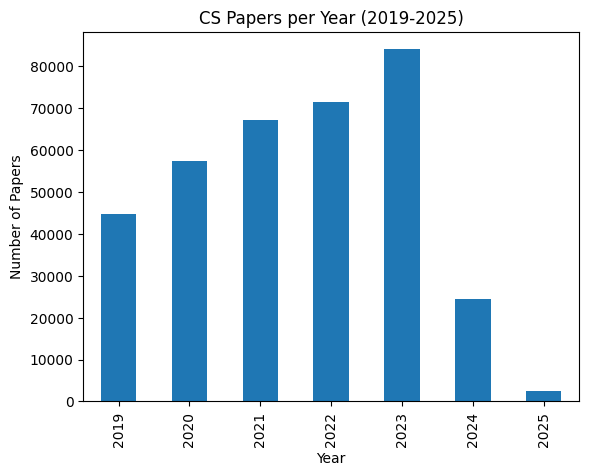

In [ ]:
# Group by year and count the number of papers per year
papers_per_year = cs_df.groupby("year").size()

# Print the counts
print(papers_per_year)

# Optionally, plot the counts as a bar chart
papers_per_year.plot(kind='bar')
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("CS Papers per Year (2019-2025)")
plt.show()

We further cleaned this data next and prepared it for training the topic model

### Regex Cleaning

In [ ]:
# Cleans data by removing whitespaces, punctuation, numbers and normalizes white space
# does this in batches of 100,000 for computational efficiency
import re

def clean_batch(batch):
    batch["clean_abstract"] = (
        batch["abstract"]
        .str.lower()
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'[^a-z\s]', '', regex=True)
        .str.strip()
        .apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    )
    return batch[batch["clean_abstract"].str.split().str.len() > 20]

# Process in batches
batch_size = 100000
cleaned_batches = []

for i in range(0, len(cs_df), batch_size):
    batch = cs_df.iloc[i:i+batch_size].copy()
    print(f"Processing batch {i // batch_size + 1}...")
    cleaned = clean_batch(batch)
    cleaned_batches.append(cleaned)

# Combine all cleaned data
df_cleaned = pd.concat(cleaned_batches, ignore_index=True)

print("Final cleaned shape:", df_cleaned.shape)
df_cleaned[["title", "clean_abstract"]].head()
df_cleaned.to_csv("cleaned_data.csv")


Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Final cleaned shape: (350431, 8)


In [ ]:
# Double check cleaned abstracts with random sample

df_cleaned[["title", "clean_abstract"]].sample(5, random_state=42)

title  \
65444   A Deep Neural Network for Finger Counting and ...   
130915  Adaptive Inference through Early-Exit Networks...   
251013                    Kernel Neural Optimal Transport   
160816  Code Representation Learning with Pr\"ufer Seq...   
141482  Compositional Abstraction Error and a Category...   

                                           clean_abstract  
65444   paper present neurorobotics models deep artifi...  
130915  dnns becoming less less overparametrised due r...  
251013  study neural optimal transport algorithm uses ...  
160816  effective efficient encoding source code compu...  
141482  interventional causal models describe several ...

As part of our preprocessing pipeline, we cleaned the `abstract` column to prepare the text data for topic modeling. This cleaning process involved converting all text to lowercase, removing punctuation, numbers, and special characters, normalizing extra whitespace, and trimming any leading or trailing spaces. We also filtered out any abstracts that contained fewer than 20 words, as they were likely too short to provide meaningful topic information.

Given the size of our filtered dataset (approximately 350,000 rows), we processed the data in batches of 100,000 rows to reduce memory usage and avoid crashes in Google Colab. Each cleaned batch was stored in a list and then concatenated into a single DataFrame, which was saved as a CSV file for further analysis.

# Section 2: Training BERT model

In [ ]:
# train BERT to extract embeddings and save to csv

# Step 1: Embed abstracts with GPU optimization
model = SentenceTransformer("all-MiniLM-L6-v2")  # Auto-uses GPU in Colab

abstracts = df_cleaned["clean_abstract"].tolist()

# Encode Embeddings

embeddings = model.encode(
    abstracts,
    show_progress_bar=True,
    batch_size=256,  # leverage GPU memory
    device='cuda'    # ensure GPU usage
)

# Externally save embeddings

np.save("embeddings.npy", embeddings)

# Step 2: Train BERTopic
topic_model = BERTopic(language="english", verbose=True)
topics, probs = topic_model.fit_transform(abstracts, embeddings)

# Save results in DataFrame
df_topics = df_cleaned.copy()
df_topics["topic"] = topics
df_topics["probability"] = probs

# Preview
df_topics[["title", "clean_abstract", "topic", "probability"]].head()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1369 [00:00<?, ?it/s]

2025-04-06 03:05:15,565 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-06 03:15:52,743 - BERTopic - Dimensionality - Completed ✓
2025-04-06 03:15:52,764 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-06 03:16:56,755 - BERTopic - Cluster - Completed ✓
2025-04-06 03:16:56,871 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-06 03:17:36,386 - BERTopic - Representation - Completed ✓


title  \
0  RF Jamming Classification using Relative Speed...   
1  How did Donald Trump Surprisingly Win the 2016...   
2  Answering Range Queries Under Local Differenti...   
3  CARP: Context-Aware Reliability Prediction of ...   
4  Image Super-Resolution via RL-CSC: When Residu...   

                                      clean_abstract  topic  probability  
0  wireless communications vulnerable radio frequ...    683     0.378222  
1  donald trump lagging behind nearly opinion pol...    123     0.861808  
2  counting fraction population input within spec...     38     0.763037  
3  reliability prediction important task software...     -1     0.000000  
4  propose simple yet effective model single imag...    140     0.889178

### Model Training: Embedding Abstracts and Topic Modeling with BERTopic

Once the abstracts were cleaned, we used the `all-MiniLM-L6-v2` model from SentenceTransformers to generate dense vector embeddings. This model is lightweight, fast, and optimized for sentence-level representations, making it a strong choice for semantic similarity tasks like topic modeling. The embedding process was accelerated using a GPU (via the `cuda` device in Colab), and we increased the batch size to 256 to take full advantage of the available GPU memory.

The resulting embeddings were saved to a `.npy` file for reuse in future steps without needing to recompute them. After embedding, we trained a BERTopic model using the English language setting. BERTopic combines the transformer-based embeddings with dimensionality reduction and clustering techniques to generate coherent topics. The model returned both the predicted topic for each document and the associated confidence probability.

We stored these results in a new DataFrame by appending the topic and probability scores to the original cleaned data. This formed the foundation for our downstream analyses, including topic frequency tracking, visualization, and subtopic clustering.

### Save Trained results to files so we don't need to retrain them

In [ ]:
# Save the DataFrame to a CSV file without the index column
df_topics.to_csv("topic_results.csv", index=False)
print("DataFrame saved to topic_results.csv")

# Save the topic model so you can inspect topics later without re-training
topic_model.save("bertopic_model.bin")

2025-04-06 03:19:43,763 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


DataFrame saved to topic_results.csv


### Saving Results and Model for Future Use

After training the BERTopic model and assigning topics to each abstract, we saved the resulting DataFrame—containing the cleaned abstracts, topic labels, and topic probabilities—to a CSV file (`topic_results.csv`). This allowed us to persist the results for further analysis, visualization, or integration into other workflows without needing to re-run the entire modeling process.

We also saved the trained BERTopic model itself (`bertopic_model.bin`) using the built-in `.save()` method. This ensures that we can later reload the model to inspect topic keywords, visualize topics, or apply it to new data, without having to retrain the model from scratch. This step was particularly important given the long training time required on our full dataset.

# Section 3: Load Results and Start Analysis

In [ ]:
print("Embeddings shape:", embeddings.shape)
print("DataFrame shape:", df_topics.shape)

Embeddings shape: (350431, 384)
DataFrame shape: (350431, 10)


In [7]:
topic_model = BERTopic.load(model_path)

ValueError: <class 'numpy.random._mt19937.MT19937'> is not a known BitGenerator module.

In [ ]:
# Load the embeddings
embeddings = np.load(embeddings_path, allow_pickle=True)

# Load the BERTopic model
topic_model = BERTopic.load(model_path)

# Load the DataFrame with your topic results
df_topics = pd.read_csv(results_path)

# Now you can continue your analysis...
print("Embeddings shape:", embeddings.shape)
print("DataFrame shape:", df_topics.shape)

Embeddings shape: (350431, 384)
DataFrame shape: (350431, 10)


### Reloading Saved Models and Data for Continued Analysis

To continue our analysis without retraining the model or regenerating embeddings, we reloaded the necessary components from disk. This included the dense vector embeddings (`embeddings.npy`), the trained BERTopic model (`bertopic_model.bin`), and the saved DataFrame containing topic labels and probabilities (`topic_results.csv`).

By loading these precomputed files, we were able to resume our workflow efficiently and immediately begin further exploration—such as visualizing topic distributions, generating word clouds, or tracking topic trends over time. This approach saved significant compute time and allowed for reproducibility of results across sessions.

In [ ]:
df_topics = pd.read_csv(results_path)

In [ ]:
# Preview structure
df_topics.head()




id                                              title  \
0  1812.11886  RF Jamming Classification using Relative Speed...   
1  1812.11891  How did Donald Trump Surprisingly Win the 2016...   
2  1812.10942  Answering Range Queries Under Local Differenti...   
3  1503.00102  CARP: Context-Aware Reliability Prediction of ...   
4  1812.11950  Image Super-Resolution via RL-CSC: When Residu...   

                                            abstract  \
0  Wireless communications are vulnerable against...   
1  Donald Trump was lagging behind in nearly all ...   
2  Counting the fraction of a population having a...   
3  Reliability prediction is an important task in...   
4  We propose a simple yet effective model for Si...   

                                    categories  \
0                                        cs.CR   
1  cs.IT cs.LG eess.SP math.IT math.OC stat.ML   
2                                        cs.DB   
3                                        cs.SE   
4                                        cs.CV   

                                             authors        date  year  \
0  [['Kosmanos', 'Dimitrios', ''], ['Karagiannis'...  2019-01-01  2019   
1  [['Xu', 'Weiyu', ''], ['Lai', 'Lifeng', ''], [...  2019-01-01  2019   
2  [['Kulkarni', 'Tejas', ''], ['Cormode', 'Graha...  2019-01-01  2019   
3  [['Zhu', 'Jieming', ''], ['He', 'Pinjia', ''],...  2019-01-01  2019   
4  [['Zhang', 'Menglei', ''], ['Liu', 'Zhou', '']...  2019-01-01  2019   

                                      clean_abstract  topic  probability  
0  wireless communications vulnerable radio frequ...    683     0.378222  
1  donald trump lagging behind nearly opinion pol...    123     0.861808  
2  counting fraction population input within spec...     38     0.763037  
3  reliability prediction important task software...     -1     0.000000  
4  propose simple yet effective model single imag...    140     0.889178

In [ ]:
# Extract Required Columns For Future Use

abstracts = df_topics["clean_abstract"].tolist()
topics = df_topics["topic"].tolist()
years = df_topics["year"].tolist()
print(len(set(years)))

7


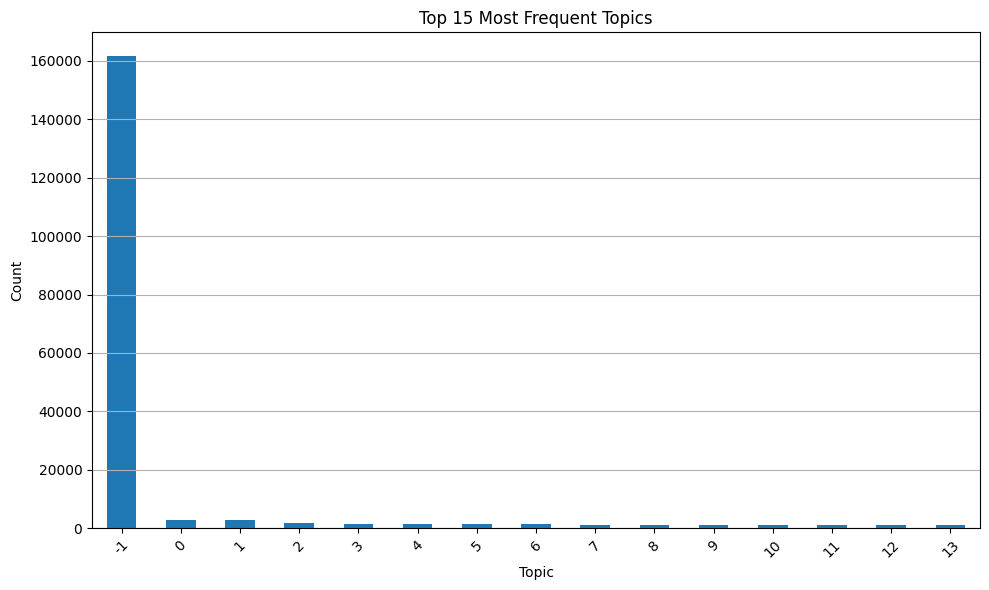

In [ ]:

# Count topic frequencies
top_counts = df_topics["topic"].value_counts().head(15)

# Plot
plt.figure(figsize=(10,6))
top_counts.plot(kind='bar')
plt.title("Top 15 Most Frequent Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 1. Check topic information and count total topics
topic_info = topic_model.get_topic_info()
print(topic_info)

      Topic   Count                                             Name  \
0        -1  161658                  -1_problems_tasks_time_language   
1         0    2821      0_adversarial_perturbations_attacks_defense   
2         1    2715                    1_fl_federated_clients_client   
3         2    1641         2_students_education_educational_courses   
4         3    1597                     3_games_nash_game_equilibria   
...     ...     ...                                              ...   
2352   2351      10            2351_facility_sscflp_facilities_mgclp   
2353   2352      10  2352_gallery_backfilling_bct_backwardcompatible   
2354   2353      10           2353_resistance_resistances_er_ldagger   
2355   2354      10           2354_surgical_surgery_stir_laparoscope   
2356   2355      10                     2355_renewable_llms_plms_gpt   

                                         Representation  \
0     [problems, tasks, time, language, system, syst...   
1     [adversaria

In [ ]:
df_topics.shape

(350431, 10)

Ok, looks like we have a lot of papers being thrown into the junk topic. These may be because of ungeneralizability or uninterpretability of certain papers. Let's remove this junk topic to interpret the data that was categorized and grouped properly by the model.

In [ ]:
# Extract all rows that belong to topic -1 (junk topic)
df_junk = df_topics[df_topics["topic"] == -1].copy()
print("Number of junk topic abstracts:", len(df_junk))

# Show a few sample titles and abstracts
df_junk[["title", "abstract", "categories"]].sample(20, random_state=42)

Number of junk topic abstracts: 161658


title  \
161732  Learning To Estimate Regions Of Attraction Of ...   
43606   Iterative and Adaptive Sampling with Spatial A...   
83638   Remote sensing image fusion based on Bayesian GAN   
191     A Puff of Steem: Security Analysis of Decentra...   
136311  Learning Order Parameters from Videos of Dynam...   
244177  Voting from Nearest Tasks: Meta-Vote Pruning o...   
328710  The medial axis of closed bounded sets is Lips...   
134532  Cloud-Enabled High-Altitude Platform Systems: ...   
323107  Can we avoid Double Descent in Deep Neural Net...   
328093                  Combinatorial Bernoulli Factories   
155808  $Q$-tensor gradient flow with quasi-entropy an...   
277861    Compositional Exemplars for In-context Learning   
347456  Deformation problem for glued elastic bodies a...   
286330  Underlaid Sensing Pilot for Integrated Sensing...   
248301  A High Order Stabilized Solver for the Volume ...   
291120  Knowledge Restore and Transfer for Multi-label...   
156427  Weighted Automata and Expressions over Pre-Rat...   
162858  Hybrid Jammer Mitigation for All-Digital mmWav...   
148085  Batched Data-Driven Evolutionary Multi-Objecti...   
158041  Bringing Light Into the Dark: A Large-scale Ev...   

                                                 abstract  \
161732  When learning to perform motor tasks in a simu...   
43606   Deep neural networks have achieved great succe...   
83638   Remote sensing image fusion technology (pan-sh...   
191     Decentralized content curation is the process ...   
136311  The ability to recognize dynamical phenomena (...   
244177  As a few large-scale pre-trained models become...   
328710  We prove that the medial axis of closed sets i...   
134532  Augmenting ground-level communications with fl...   
323107  Finding the optimal size of deep learning mode...   
328093  A Bernoulli factory is an algorithmic procedur...   
155808  We propose and analyze numerical schemes for t...   
277861  Large pretrained language models (LMs) have sh...   
347456  We study a mathematical model for deformation ...   
286330  This paper investigates a novel underlaid sens...   
248301  The Volume-Averaged Navier-Stokes equations ar...   
291120  Current class-incremental learning research ma...   
156427  The Kleene theorem establishes a fundamental l...   
162858  Low-resolution analog-to-digital converters (A...   
148085  Multi-objective optimization problems are ubiq...   
158041  The heterogeneity in recently published knowle...   

                               categories  
161732                              cs.LG  
43606                               cs.CV  
83638                               cs.CV  
191                                 cs.MA  
136311                        cs.LG cs.CV  
244177                              cs.LG  
328710                              cs.CG  
134532                              cs.NI  
323107                        cs.LG cs.AI  
328093  cs.DS cs.DM cs.GT math.CO math.PR  
155808                      math.NA cs.NA  
277861                  cs.CL cs.AI cs.LG  
347456                      math.NA cs.NA  
286330              cs.IT eess.SP math.IT  
248301      math.NA cs.NA physics.flu-dyn  
291120                              cs.CV  
156427                              cs.FL  
162858              cs.IT eess.SP math.IT  
148085                              cs.NE  
158041                cs.LG cs.AI stat.ML

But before throwing all of these papers out, let's take a look at the common word combinations drawing certain papers into this general uninterpretable bucket.

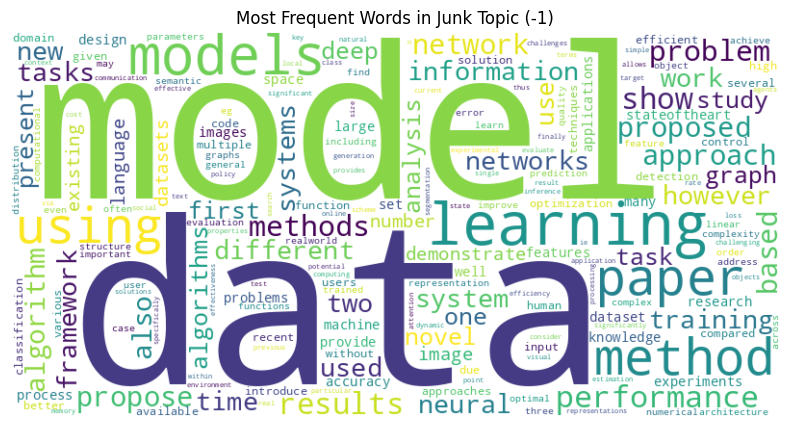

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join all junk abstracts into one string
junk_text = ' '.join(df_junk["clean_abstract"].dropna().tolist())

# Create word frequency dictionary
word_freq = Counter(junk_text.split())

# Generate word cloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Junk Topic (-1)")
plt.show()

In [ ]:
# Show a few sample titles and abstracts
df_topics[["title", "abstract", "categories", "topic"]].sample(20, random_state=42)

title  \
65444   A Deep Neural Network for Finger Counting and ...   
130915  Adaptive Inference through Early-Exit Networks...   
251013                    Kernel Neural Optimal Transport   
160816  Code Representation Learning with Pr\"ufer Seq...   
141482  Compositional Abstraction Error and a Category...   
3620    Structural Invariants for Parametric Verificat...   
40877   Optimized geometrical metrics satisfying free-...   
235076  Ghost-free High Dynamic Range Imaging via Hybr...   
268178  Fairness and Diversity in Information Access S...   
11501   Biphasic Learning of GANs for High-Resolution ...   
171561  POPPINS : A Population-Based Digital Spiking N...   
55545   Video-based Person Re-Identification using Gat...   
244968  Online Learning Based Mobile Robot Controller ...   
332475  Importance of Small Probability Events in Big ...   
85018   On the probabilistic feasibility of solutions ...   
22243   Evaluating the distribution learning capabilit...   
301550  Learning to Locate Visual Answer in Video Corp...   
160678  Public Policymaking for International Agricult...   
306966  Decoding Modular Reconfigurable Robots: A Surv...   
276118  Reducing Barriers to Self-Supervised Learning:...   

                                                 abstract  \
65444   In this paper, we present neuro-robotics model...   
130915  DNNs are becoming less and less over-parametri...   
251013  We study the Neural Optimal Transport (NOT) al...   
160816  An effective and efficient encoding of the sou...   
141482  Interventional causal models describe several ...   
3620    We consider concurrent systems consisting of a...   
40877   Computational fluid dynamics and aerodynamics,...   
235076  Eliminating ghosting artifacts due to moving o...   
268178  Among the seven key requirements to achieve tr...   
11501   Despite that the performance of image-to-image...   
171561  The inner operations of the human brain as a b...   
55545   Deep neural networks have been successfully ap...   
244968  Slip is a very common phenomena present in whe...   
332475  In many applications (e.g., anomaly detection ...   
85018   We investigate the probabilistic feasibility o...   
22243   We evaluate the distribution learning capabili...   
301550  We introduce a new task, named video corpus vi...   
160678  International economics has a long history of ...   
306966  The intrinsic modularity and reconfigurability...   
276118  Self-supervised learning (SSL) has led to grea...   

                                           categories  topic  
65444                       cs.CV cs.LG cs.RO stat.ML     -1  
130915                                          cs.LG     -1  
251013                                  cs.LG stat.ML    105  
160816                                          cs.AI     -1  
141482              stat.ML cs.AI cs.LG cs.LO math.CT      6  
3620                                            cs.FL     -1  
40877   math.NA cs.NA physics.comp-ph physics.flu-dyn     -1  
235076                                  cs.CV eess.IV    540  
268178                                          cs.IR     11  
11501                                           cs.CV   1159  
171561                                    cs.NE cs.AI    441  
55545                                           cs.CV     58  
244968                            cs.RO cs.SY eess.SY     -1  
332475                  cs.IT math.IT math.ST stat.TH   2140  
85018                           math.OC cs.SY eess.SY     -1  
22243                             cs.LG cs.CV stat.ML     20  
301550                                    cs.CV cs.CL    950  
160678                   cs.LG cs.AI econ.GN q-fin.EC   1267  
306966                                          cs.RO     -1  
276118                            cs.CL cs.AI eess.AS    888

It looks like these are filled with general quantitative and statistical terminology making the papers hard to group, likely due to abundance of these general terms and relative lack of density of specialized words and phrases. We will remove them for now.

In [ ]:
# topic -1 is a junk topic (words like "of and in for"), so remove it
df_topics = df_topics[df_topics["topic"] != -1]

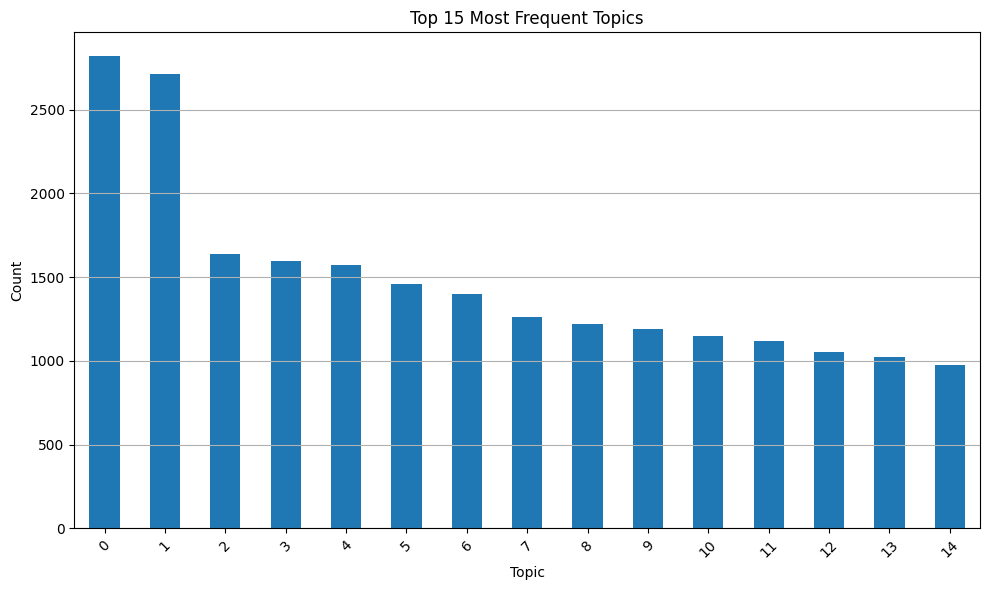

In [ ]:
# Recount topic frequencies after removing junk topic
top_counts = df_topics["topic"].value_counts().head(15)

# Plot
plt.figure(figsize=(10,6))
top_counts.plot(kind='bar')
plt.title("Top 15 Most Frequent Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Check how many unique topics remain after filtering out -1
unique_topics = df_topics["topic"].nunique()
print("Number of topics (excluding outlier -1):", unique_topics)

Number of topics (excluding outlier -1): 2356


### Topic Frequency Analysis and Junk Topic Removal

To better understand the distribution of topics generated by the BERTopic model, we calculated the frequency of each topic and visualized the top 15 most common topics using a bar chart. This helped us identify which themes were most prevalent across the dataset.

Upon inspection of the topic metadata (via `get_topic_info()`), we observed that one topic—labeled as `-1`—contained over 160,000 documents and was made up almost entirely of common stopwords such as "of," "and," "in," and "for." This indicated that topic `-1` was a generic or "junk" topic where BERTopic was unable to confidently assign a meaningful cluster.

To ensure cleaner and more interpretable results, we removed all rows associated with topic `-1` from the dataset before proceeding with further analysis and visualization. This step significantly improved the relevance and coherence of the remaining topics.

In [ ]:
df_topics.shape

(188773, 10)

df

Let's randomly select a topic to see if the papers within it are thematically appropriate.

In [ ]:
# Retrieve and print details (keywords and weights) for topic 2560
topic_details = topic_model.get_topic(2560)
print("Topic 2560 details:", topic_details)

Topic 2560 details: False


In [ ]:
# Filter the DataFrame for papers assigned to topic 2560
topic_2560_df = df_topics[df_topics["topic"] == 2560]
print("Papers in topic 2560:")
print(topic_2560_df[["title", "clean_abstract", "topic"]])

Papers in topic 2560:
                                                    title  \
134468  CCC/Code 8.7: Applying AI in the Fight Against...   
177465  Ethics and Efficacy of Unsolicited Anti-Traffi...   
192894  Desaparecidxs: characterizing the population o...   
202170  Estimating Effectiveness of Identifying Human ...   
223667  Operations Research and Analytics to Combat Hu...   
239507  Perspectives on How To Conduct Responsible Ant...   
241053  Selling sex: what determines rates and popular...   
242470  A Transdisciplinary Approach for Generating Sy...   
297815  Machine Learning for Tangible Effects: Natural...   
318549  Combatting Human Trafficking in the Cyberspace...   

                                           clean_abstract  topic  
134468  on any given day tens of millions of people fi...   2560  
177465  the sex industry exists on a continuum based o...   2560  
192894  missing children ie children reported to a rel...   2560  
202170  transit monitoring is a preven

The model seems to be accurate here, a topic with high density of ethics and human rights terminology has papers within it based on human rights, ethics and exploitation.

In [ ]:
df_topics.columns

Index(['id', 'title', 'abstract', 'categories', 'authors', 'date', 'year',
       'clean_abstract', 'topic', 'probability'],
      dtype='object')

Now we will begin with our main analysis of the dataset

# **Topic Representation**

In [ ]:
topic_model.get_topic_info().head(41)

Topic   Count                                               Name  \
0      -1  161658                    -1_problems_tasks_time_language   
1       0    2821        0_adversarial_perturbations_attacks_defense   
2       1    2715                      1_fl_federated_clients_client   
3       2    1641           2_students_education_educational_courses   
4       3    1597                       3_games_nash_game_equilibria   
5       4    1571    4_blockchain_blockchains_consensus_transactions   
6       5    1460            5_recommendation_recommender_item_items   
7       6    1399         6_causal_treatment_observational_causality   
8       7    1264                          7_nmt_translation_mt_bleu   
9       8    1221           8_control_controller_lyapunov_closedloop   
10      9    1193                       9_bandit_bandits_regret_arms   
11     10    1146             10_anomaly_anomalies_anomalous_outlier   
12     11    1121              11_fairness_fair_unfairness_protected   
13     12    1054                         12_asr_speech_wer_acoustic   
14     13    1023               13_clinical_biomedical_notes_medical   
15     14     977                   14_nerf_rendering_radiance_nerfs   
16     15     955                15_multirobot_swarm_planning_robots   
17     16     877                  16_pdes_pinns_pde_physicsinformed   
18     17     812               17_retrieval_ranking_documents_query   
19     18     804                      18_detectors_coco_object_detr   
20     19     780                       19_codes_selfdual_mds_cyclic   
21     20     775                20_gans_gan_discriminator_generator   
22     21     773                21_sound_audio_audiovisual_acoustic   
23     22     757                      22_type_calculus_monads_monad   
24     23     754  23_transformers_transformer_selfattention_atte...   
25     24     736        24_citation_citations_journals_publications   
26     25     714                 25_convex_stochastic_nonconvex_sgd   
27     26     708     26_summarization_summaries_abstractive_summary   
28     27     691                   27_quantum_computers_qubo_qubits   
29     28     690          28_dialogue_dialog_taskoriented_dialogues   
30     29     680                     29_gnns_gnn_oversmoothing_gcns   
31     30     659                       30_music_musical_melody_midi   
32     31     649                     31_renewable_power_opf_voltage   
33     32     635                    32_adaptation_uda_domain_target   
34     33     635                    33_vits_vit_transformers_vision   
35     34     620           34_lidar_clouds_lidarbased_semantickitti   
36     35     617                   35_mot_tracking_trackers_tracker   
37     36     607              36_marl_multiagent_agents_cooperative   
38     37     606                       37_nas_search_darts_supernet   
39     38     605              38_privacy_differentially_private_ldp   
40     39     587            39_continual_forgetting_catastrophic_cl   

                                       Representation  \
0   [problems, tasks, time, language, system, syst...   
1   [adversarial, perturbations, attacks, defense,...   
2   [fl, federated, clients, client, server, nonii...   
3   [students, education, educational, courses, st...   
4   [games, nash, game, equilibria, equilibrium, p...   
5   [blockchain, blockchains, consensus, transacti...   
6   [recommendation, recommender, item, items, use...   
7   [causal, treatment, observational, causality, ...   
8   [nmt, translation, mt, bleu, translations, wmt...   
9   [control, controller, lyapunov, closedloop, mp...   
10  [bandit, bandits, regret, arms, multiarmed, ar...   
11  [anomaly, anomalies, anomalous, outlier, norma...   
12  [fairness, fair, unfairness, protected, discri...   
13  [asr, speech, wer, acoustic, librispeech, rnnt...   
14  [clinical, biomedical, notes, medical, icd, nl...   
15  [nerf, rendering, radiance, nerfs, lighting, s...   
16  [multi

From an initial review of the topic table, it is evident that the BERTopic model has been able to extract several meaningful topics. The most frequent topics emerge with strong thematic identities — ranging from reinforcement learning and adversarial attacks to molecular modeling and time series forecasting — which align closely with well-established research domains. This means that the topic model is categorizing and grouping the data well.

However, one potential issue is the prevalence of outliers, grouped under Topic -1, which represents over 160,000 documents. Not all documents fit neatly into cohesive clusters, a common topic-modelling problem. Despite this, the remaining topics — especially the top 10–15 — reveal clear and well-separated thematic groupings.

**Word Cloud of most frequent words in the first 10 topics**

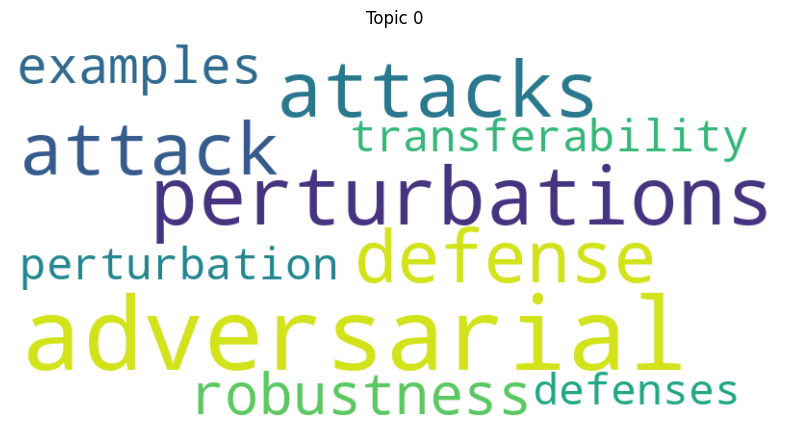

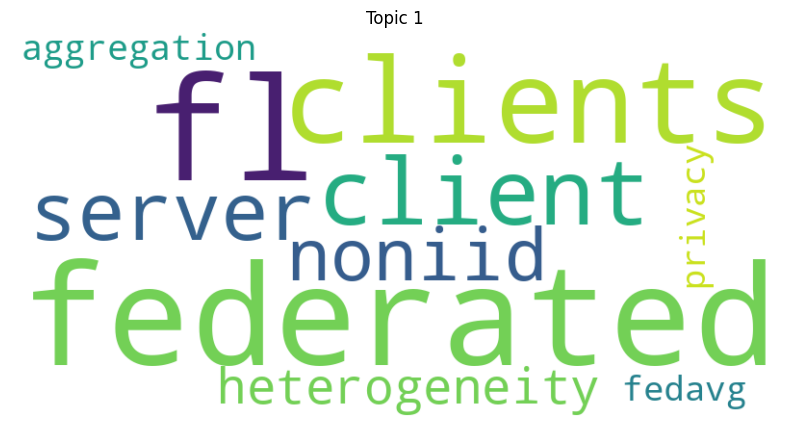

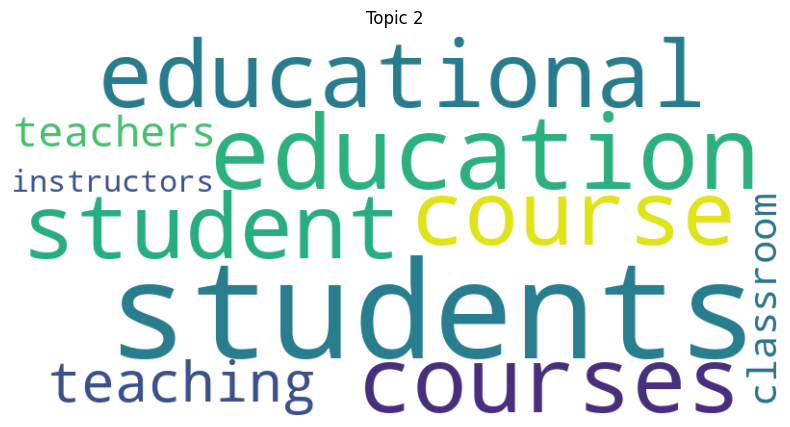

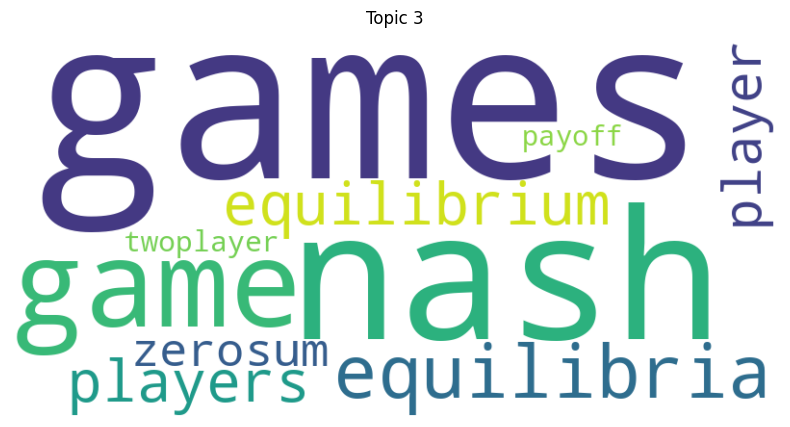

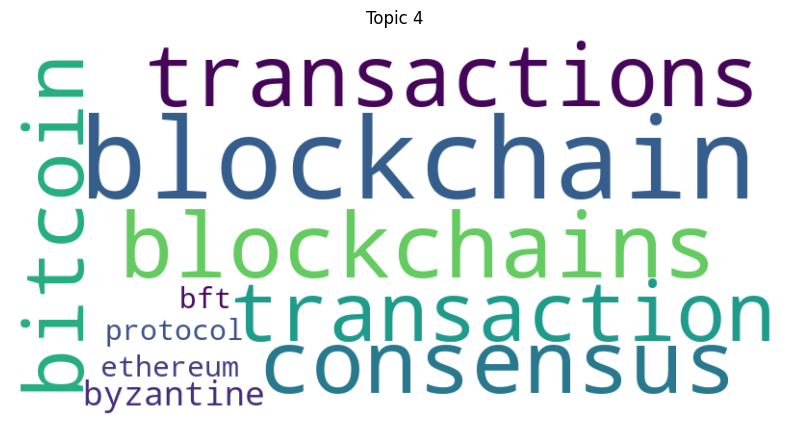

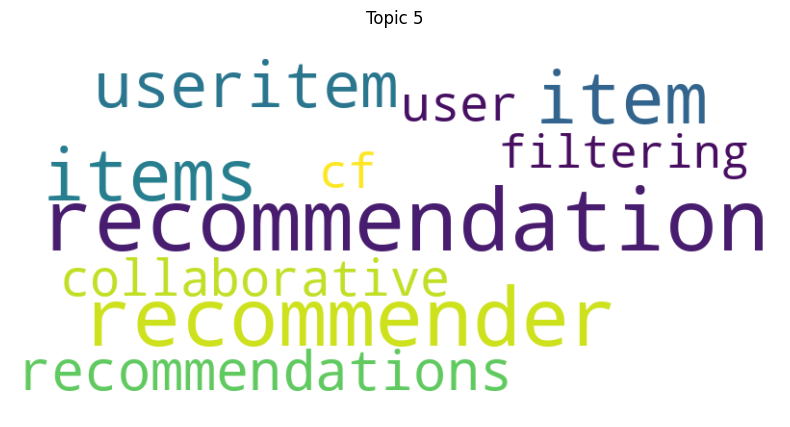

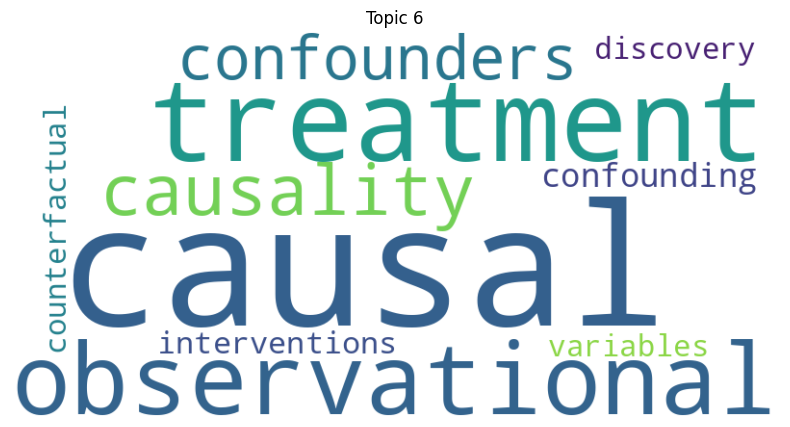

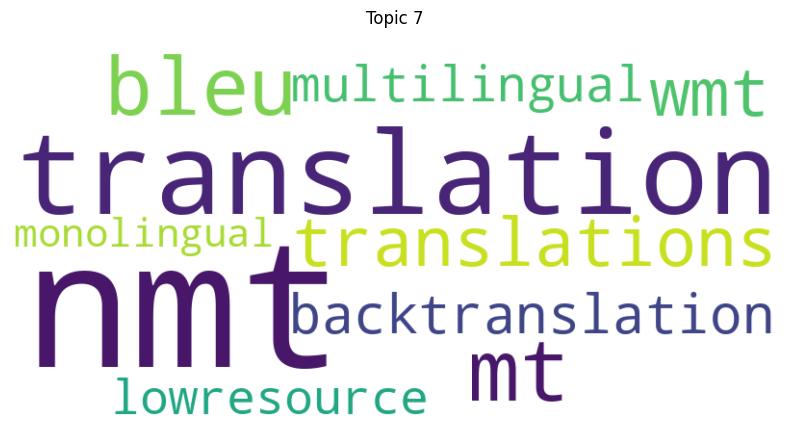

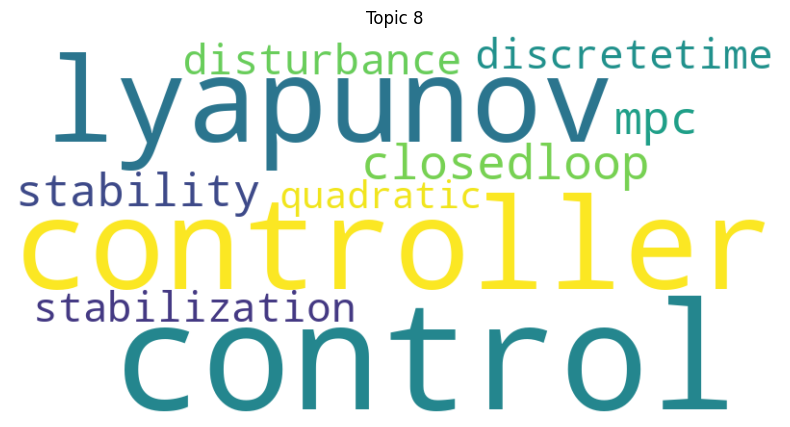

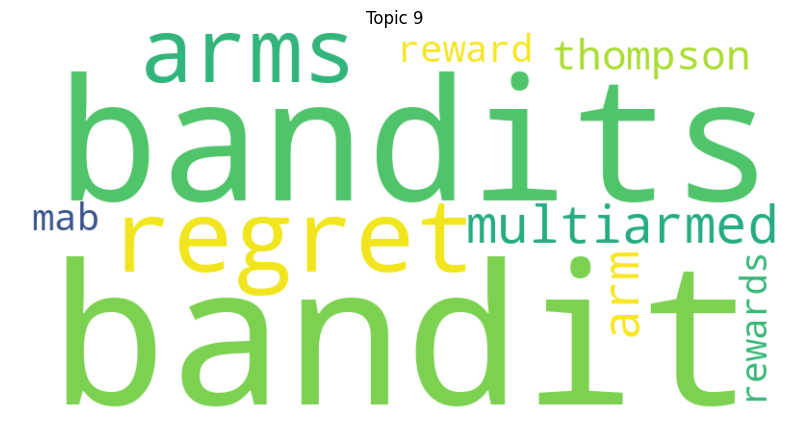

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the topic information from the fitted BERTopic model
topic_info = topic_model.get_topic_info()

# Generate word clouds for a subset of topics (e.g., top 10)
top_n = 10
top_topics = topic_info[topic_info.Topic != -1].head(top_n)["Topic"].tolist()

# Loop through and generate word clouds
for topic in top_topics:
    words = topic_model.get_topic(topic)
    if words:
        word_freq = {word: weight for word, weight in words}

        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic}")
        plt.show()

In [ ]:
topic_model.visualize_barchart(top_n_topics=12, height=700)

**Top 12 Most Confident Predicted Topics Below**

In [ ]:
# Compute average probability per topic
avg_confidence = df_topics.groupby("topic")["probability"].mean().sort_values(ascending=False)

# Select top 12 most confidently predicted topics
top_confident_topics = avg_confidence.head(12).index.tolist()
# Pass the selected topics to BERTopic's visualization method
fig = topic_model.visualize_barchart(top_n_topics=12, topics=top_confident_topics, height=700)
fig.show()

**Abstracts Sample**

In [ ]:
# Filter for Topic 3
df_topic1 = df_topics[df_topics["topic"] == 3]

# Show a few samples (with category, title, and abstract)
df_topic1[["categories", "title", "abstract"]].sample(5, random_state=42)

categories  \
177841  cs.CC cs.AI cs.DM cs.DS math.CO   
27393                       cs.GT cs.LO   
70825                     cs.LG stat.ML   
147770                    math.OC cs.LG   
297305                            cs.GT   

                                                    title  \
177841  Nimber-Preserving Reductions and Homomorphic S...   
27393     Games on graphs with a public signal monitoring   
70825   Reproducibility Challenge NeurIPS 2019 Report ...   
147770  Constants of Motion: The Antidote to Chaos in ...   
297305  Episodic Logit-Q Dynamics for Efficient Learni...   

                                                 abstract  
177841  The concept of nimbers--a.k.a. Grundy-values o...  
27393   We study pure Nash equilibria in games on grap...  
70825   This is a report for reproducibility challenge...  
147770  Several recent works in online optimization an...  
297305  We present new learning dynamics combining (in...

### Topic Word Score Analysis

The topic word scores visualization reveals the most important terms that define each topic, ranked by their relevance within the cluster.

One of the clearest patterns is the strong presence of concentrated vocabularies in several topics. For example, Topic 0 is heavily centered on the language of adversarial attacks, with “adversarial,” “perturbations,” “attacks,” “defense,” and “attack” dominating the cluster. Similarly, Topic 1 revolves around federated learning, with terms like “fl,” “federated,” “clients,” and “server.” The compactness of these vocabularies indicates that some areas of research are semantically narrow, characterized by consistent terminology. This enables the model to sharply cluster papers using just a few dominant signals. We see comparable tight cores in Topic 4 (blockchain systems) and Topic 5 (recommender systems), where a small set of recurring keywords anchors the topic definition.

In contrast, other topics exhibit a more gradual decline in word relevance, suggesting broader or more interdisciplinary domains. For instance, Topic 2, which focuses on education and learning environments, features “students,” “education,” “educational,” “courses,” and “student” — but the relevance scores between terms are more evenly distributed. This may reflect the diversity of contexts in which education-related work appears, spanning human-computer interaction, pedagogy, and cognitive modeling. Topic 10 (anomaly detection) and Topic 11 (fairness in machine learning) also show a similar distribution, possibly due to their methodological generality and their application across a wide range of domains.

A particularly important observation is the lack of term overlap across the top-ranked words of different topics. Even thematically adjacent clusters, such as Topic 6 (causal inference) and Topic 7 (machine translation), maintain distinct vocabularies — e.g., “causal,” “treatment,” “confounders” vs. “nmt,” “translation,” “bleu.” This reinforces the effectiveness of the model in capturing semantic nuance. The clear linguistic separation between topics underscores both the coherence of individual clusters and the robustness of the underlying embeddings.

In [ ]:
topic_model.visualize_term_rank()


In [ ]:
topic_model.visualize_term_rank(log_scale=True)

### Term Score Decline Analysis

Let's analyze the Term Score Decline per Topic to get a broader statistical look at how terms within each topic are ranked in terms of importance. The graph reveals a consistent and predictable trend: a steep initial drop in term importance from the first to the second most relevant word, followed by a gradually flattening curve for the remaining terms. This shape mimics the classic "elbow" pattern found in many ranking and optimization tasks.

It looks like there is strong uniformity across topics — the overwhelming majority of lines follow similar downward trajectories, indicating that topics in this corpus tend to be sharply focused around a small handful of dominant keywords. For nearly all topics, term scores drop sharply from rank 1 to rank 3, with diminishing returns beyond that point. This suggests that around 3-5 words is the key threshold to minimize noise while maintaining strong interpretability.


# **Topic Relationships Analysis**

In [ ]:
topic_model.visualize_topics(top_n_topics=50)

The Intertopic Distance Map provides a high-level spatial overview of how semantically distinct or similar the generated topics are relative to one another. Each circle in the map represents a topic, where the size of the circle reflects the relative frequency of that topic in the dataset, and the distance between circles represents their semantic similarity.

At first glance, the plot reveals a relatively dense clustering of topics with a high semantical distance between clusters. The tightness of this central cluster implies that while distinct, many topics are not radically different from one another, supporting the notion that the dataset is topically cohesive.

There are many dispersed clusters, especially for clusters with topics related to sound/music, literature and ethics. This suggests that there are many niche topics in academia with little overlap.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50, width=1000)

To better understand and visualize the similarity between topics, we can use a hierarchical clustering dendrogram. We will incorporate the top 50 topics from the model to provide a more refined and interpretable view of semantic relationships within the corpus.

A key observation is the formation of tight, cohesive subclusters among computer vision and deep learning-related topics. For instance, Topics 33 (ViTs), 23 (Transformers), and 47 (CNN pooling) are closely grouped, suggesting that visual recognition architectures share strong semantic overlap. This is further reinforced by their proximity to Topic 37 (Neural architecture search), which naturally connects to model design and optimization.

Another prominent cluster emerges among Topics 20 (GANs), 9 (Bandit algorithms), and 36 (Multi-agent systems). These groupings highlight a methodological nexus around learning in uncertain or adversarial environments—reinforcing that these techniques are often used in conjunction and appear frequently together in research papers.

Lower down the dendrogram, we see Topics 5 (Recommendation systems), 2 (Education), and 24 (Citation networks) forming a distinct branch that merges only at higher distance thresholds. This aligns with their unique domain focus (e.g., personalization, pedagogy, and scientometrics), which diverges from the more technical or model-centric content of the rest of the corpus. Their late merge into the broader tree confirms their semantic distinctiveness, mirroring their peripheral placement in the intertopic distance map.

In terms of social impact-oriented topics, Topics 11 (Fairness), 40 (Gender bias), and 26 (Summarization) form a loosely connected chain. While fairness and bias are expected to be semantically related, the link to summarization is interesting—it may reflect emerging interdisciplinary work around equitable information presentation or responsible NLP, an implication worth investigating further.

Lastly, topics at the top of the dendrogram, such as 27 (Quantum computing), 22 (Type theory), and 49 (Topological data analysis), are slow to merge with others, confirming their outlier status in terms of semantic and technical uniqueness. These fields often have highly specialized vocabularies and are less integrated with the machine learning core of the corpus.


In [ ]:
topic_model.visualize_heatmap(n_clusters=20, top_n_topics=100)

For an even simpler at a glance look at the similarity between topics, we can turn to the similarity matrix. The similarity matrix provides a fine-grained, pairwise view of topic relationships by quantifying semantic similarity scores between all topic pairs. Unlike the hierarchical dendrogram which groups topics through progressive clustering, this matrix reveals both local and global patterns at once, making it easier to identify isolated topics and strongly interconnected pairs.

A few darker blocks off the diagonal indicate tightly connected topic clusters. For example, Topics 13 (Clinical notes), 44 (Medical segmentation), and 84 (Noisy label noise) form a visibly strong submatrix, reflecting the interrelated nature of medical AI tasks, especially where noisy data and segmentation play key roles in clinical imaging. Similarly, we observe consistent similarity between Topics 0 (Adversarial learning), 86 (Policy/off-policy learning), and 54 (Visualization), pointing to frequent co-appearance of these themes in reinforcement learning research workflows.

In contrast, certain rows and columns are lighter overall—indicating relative isolation. Notably, Topic 27 (Quantum computing) and Topic 91 (Fractional calculus) display limited similarity to others, reaffirming their outlier status seen earlier in the hierarchical clustering. These topics likely rely on niche vocabularies and appear in domain-specific contexts outside the deep learning mainstream.

Interestingly, Topic 40 (Gender bias) and Topic 72 (Legal/court law) show higher similarity scores with a broader range of topics than expected. This may suggest increasing interdisciplinarity, where fairness or legal considerations are being integrated into more technical discussions—such as in facial recognition or data privacy research.

# **Temporal Trend Analysis**

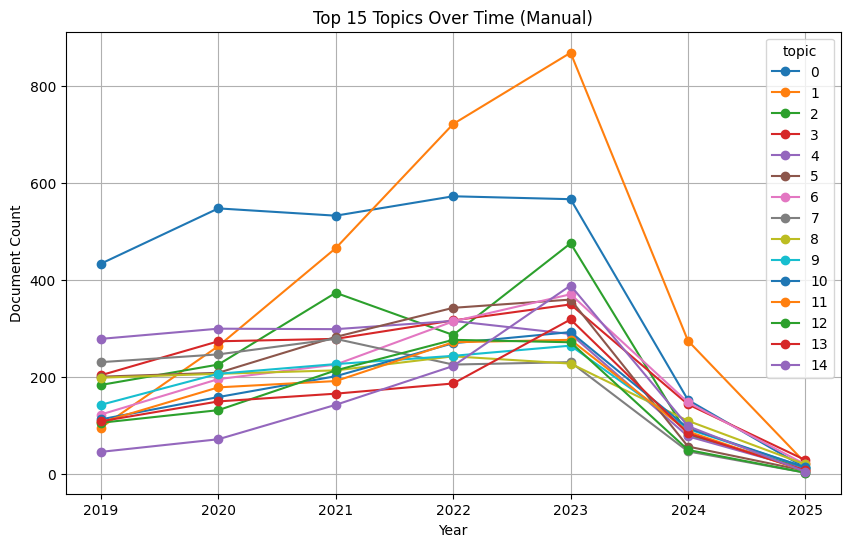

In [ ]:
# Reconstruct the DataFrame properly
df_valid = df_topics[df_topics["topic"] != -1]
topics_valid = df_valid["topic"].tolist()
years_valid = df_valid["year"].tolist()
abstracts_valid = df_valid["clean_abstract"].tolist()

df_counts = df_valid.groupby(["year", "topic"]).size().reset_index(name="Frequency")

top_n = 15

# Sum frequency across all years, then pick the largest
top_topics = (
    df_counts.groupby("topic")["Frequency"]
    .sum()
    .nlargest(top_n)
    .index
)

# Filter df_counts to only those topics
df_top = df_counts[df_counts["topic"].isin(top_topics)].copy()

df_pivot = df_top.pivot(index="year", columns="topic", values="Frequency").fillna(0)

# Now each column is a topic, each row is a year
df_pivot

plt.figure(figsize=(10, 6))
df_pivot.plot(kind="line", marker='o', ax=plt.gca())
plt.title("Top 15 Topics Over Time (Manual)")
plt.xlabel("Year")
plt.ylabel("Document Count")
plt.grid(True)
plt.show()

The “Top 15 Topics Over Time” plot reveals notable shifts in research attention across different subfields between 2019 and 2025. Topic 0 (adversarial perturbations, attacks, defense) emerges as the most dynamic, displaying a sharp and sustained rise from 2020 onward, peaking in 2023 before dropping substantially in 2024 and 2025. This surge aligns with increasing concerns about the reliability and robustness of machine learning systems, particularly in security-sensitive applications.

Topic 1 (federated learning, client systems) also shows strong upward momentum, indicating growing interest in decentralized learning paradigms—likely a response to increasing demands for privacy-preserving AI. Its consistent year-over-year growth suggests that it is not just a passing trend but a foundational shift in how machine learning models are deployed.

Topics 4 (blockchain consensus), 5 (recommendation systems), and 6 (causal inference) exhibit a slower but steady rise until 2023, showing resilience across years. These areas reflect sustained real-world applicability—blockchain in fintech and infrastructure, recommender systems in consumer applications, and causal inference in scientific and policy domains.

Topic 2 (educational AI), Topic 3 (game theory), and Topic 10 (anomaly detection) show more modest but consistent trajectories through 2023, suggesting they remain niche but active research spaces. Topic 11 (AI fairness and protected groups) sees a strong climb between 2021 and 2023, likely reflecting growing societal focus on bias, discrimination, and ethics in automated systems.

Across the board, nearly every topic exhibits a sharp decline in 2024 and 2025. This pattern likely reflects incomplete data collection for the most recent years rather than actual collapse in research interest. However, the drop is relatively more muted for topics like federated learning and recommendation systems, implying these areas might maintain stronger momentum into the near future.

# Analysis of Topic 1 (Privacy) Growth and its Relationship to Blockchain (Topic 4)
The "Top 15 Topics Over Time" plot clearly highlights Topic 1 as one of the fastest-growing topics between 2019 and 2023, peaking in 2023 before experiencing a sharp decline. In contrast, Topic 0, which had initially been the most prevalent, remained relatively stable. The trajectory of Topic 1 aligns closely with global real-world developments in federated systems, privacy, and cybersecurity, particularly in response to the rapid expansion of blockchain-based technologies.

The dendrogram you provided supports this connection, showing that Topic 1 (federated learning and privacy) clusters tightly with Topic 4 (blockchain and consensus mechanisms), as well as Topic 38 (privacy-preserving systems). This proximity in the hierarchical clustering suggests strong thematic overlap — most likely due to shared concerns around data decentralization, trustless systems, and security.

We can further confirm the nature of these topics using your word clouds:

Topic 1 contains terms like federated, client, server, privacy, and non-IID, indicating research on distributed machine learning architectures and privacy-preserving technologies.
Topic 4 is centered around blockchain, transactions, consensus, ethereum, and bitcoin, clearly pointing toward decentralized finance and trustless transaction systems.
The rise in Topic 1 from 2019–2023 mirrors a period where blockchain and cryptocurrency technologies gained mainstream adoption. Bitcoin hit an all-time high in 2021, and Ethereum usage surged due to DeFi and NFTs. Simultaneously, cybersecurity threats also escalated — the rise of ransomware attacks using cryptocurrencies and growing concerns over centralized data breaches encouraged exploration into federated learning and blockchain-based security models.

Connecting Trends to Real-World Events
These trends are not isolated. According to Investopedia, Bitcoin’s price surge peaked in April 2021, signaling the peak of public and institutional attention toward blockchain. At the same time, blockchain-related crimes also increased — Chainalysis reports that $14 billion in cryptocurrency was linked to illicit activity in 2021. These concerns fueled an academic response, explaining the thematic growth in Topic 1, with research tackling privacy, trust, decentralization, and secure model training.

In addition, the term score plot for Topic 1 confirms a tightly clustered vocabulary — with “fl”, “federated”, and “client” scoring far higher than subsequent terms. This sharp decline indicates that Topic 1 papers converge strongly on a small, specific vocabulary, reflecting a focused and maturing research domain — one that likely spun off in response to the challenges posed by blockchain’s rise.

# Topics per Class Analysis

Ok now let's perform some analysis of the fields of study and research purview relative to the topics and papers

In [ ]:
df_valid.head()


id                                              title  \
0  1812.11886  RF Jamming Classification using Relative Speed...   
1  1812.11891  How did Donald Trump Surprisingly Win the 2016...   
2  1812.10942  Answering Range Queries Under Local Differenti...   
4  1812.11950  Image Super-Resolution via RL-CSC: When Residu...   
7  1803.09112  To overlap or not to overlap: Enabling Channel...   

                                            abstract  \
0  Wireless communications are vulnerable against...   
1  Donald Trump was lagging behind in nearly all ...   
2  Counting the fraction of a population having a...   
4  We propose a simple yet effective model for Si...   
7  Wireless local area networks (WLANs) are the m...   

                                    categories  \
0                                        cs.CR   
1  cs.IT cs.LG eess.SP math.IT math.OC stat.ML   
2                                        cs.DB   
4                                        cs.CV   
7                                        cs.NI   

                                             authors        date  year  \
0  [['Kosmanos', 'Dimitrios', ''], ['Karagiannis'...  2019-01-01  2019   
1  [['Xu', 'Weiyu', ''], ['Lai', 'Lifeng', ''], [...  2019-01-01  2019   
2  [['Kulkarni', 'Tejas', ''], ['Cormode', 'Graha...  2019-01-01  2019   
4  [['Zhang', 'Menglei', ''], ['Liu', 'Zhou', '']...  2019-01-01  2019   
7  [['Barrachina-Muñoz', 'Sergio', ''], ['Wilhelm...  2019-01-01  2019   

                                      clean_abstract  topic  probability  
0  wireless communications vulnerable radio frequ...    683     0.378222  
1  donald trump lagging behind nearly opinion pol...    123     0.861808  
2  counting fraction population input within spec...     38     0.763037  
4  propose simple yet effective model single imag...    140     0.889178  
7  wireless local area networks wlans popular kin...    336     0.893779

In [ ]:
# Extract all three from df_valid to ensure perfect alignment
abstracts_valid = df_valid["clean_abstract"].tolist()
topics_valid = df_valid["topic"].tolist()
categories_valid = df_valid["categories"].tolist()


We'll need a dictionary to match academic prefixes to full category names

In [ ]:
category_map = {
    "cs.AI": "Artificial Intelligence",
    "cs.AR": "Hardware Architecture",
    "cs.CC": "Computational Complexity",
    "cs.CE": "Computer Engineering",
    "cs.CL": "Computation and Language",
    "cs.CR": "Cryptography and Security",
    "cs.CV": "Computer Vision",
    "cs.DB": "Databases",
    "cs.DC": "Distributed Computing",
    "cs.DL": "Digital Libraries",
    "cs.DM": "Discrete Mathematics",
    "cs.DS": "Data Structures",
    "cs.ET": "Emerging Technologies",
    "cs.GT": "Game Theory",
    "cs.HC": "Human-Computer Interaction",
    "cs.IR": "Information Retrieval",
    "cs.IT": "Information Theory (CS)",
    "cs.LG": "Machine Learning",
    "cs.LO": "Logic in Computer Science",
    "cs.MA": "Multiagent Systems",
    "cs.MM": "Multimedia",
    "cs.NE": "Neural and Evolutionary Computing",
    "cs.NI": "Networking and Internet Architecture",
    "cs.OS": "Operating Systems",
    "cs.PL": "Programming Languages",
    "cs.RO": "Robotics",
    "cs.SC": "Symbolic Computation",
    "cs.SD": "Sound",
    "cs.SE": "Software Engineering",
    "cs.SI": "Social and Information Networks",
    "cs.SY": "Systems and Control",
    "cs.CY": "Computational Physics",
    "cs.NA": "Numerical Analysis",
    "math.AP": "Analysis of PDEs",
    "math.CO": "Combinatorics",
    "math.DS": "Dynamical Systems",
    "math.OC": "Optimization and Control",
    "math.ST": "Statistics Theory",
    "math.IT": "Information Theory (Math)",
    "math.NA": "Numerical Analysis",
    "math.NT": "Number Theory",
    "math.OA": "Operator Algebras",
    "math.PR": "Probability",
    "stat.ML": "Statistical Machine Learning",
    "stat.AP": "Applied Statistics",
    "stat.CO": "Computation (Stats)",
    "astro-ph.EP": "Earth and Planetary Astrophysics",
    "physics.comp-ph": "Computational Physics",
    "eess.SP": "Signal Processing",
    "eess.IV": "Image and Video Processing",
    "eess.SY": "Systems and Control",
    "eess.AS": "Audio and Speech Processing",
    "eess.NA": "Numerical Analysis",
}


Now we're ready to plot a meaninful topical graph

<ipython-input-83-4d26c1639b2f>:34: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



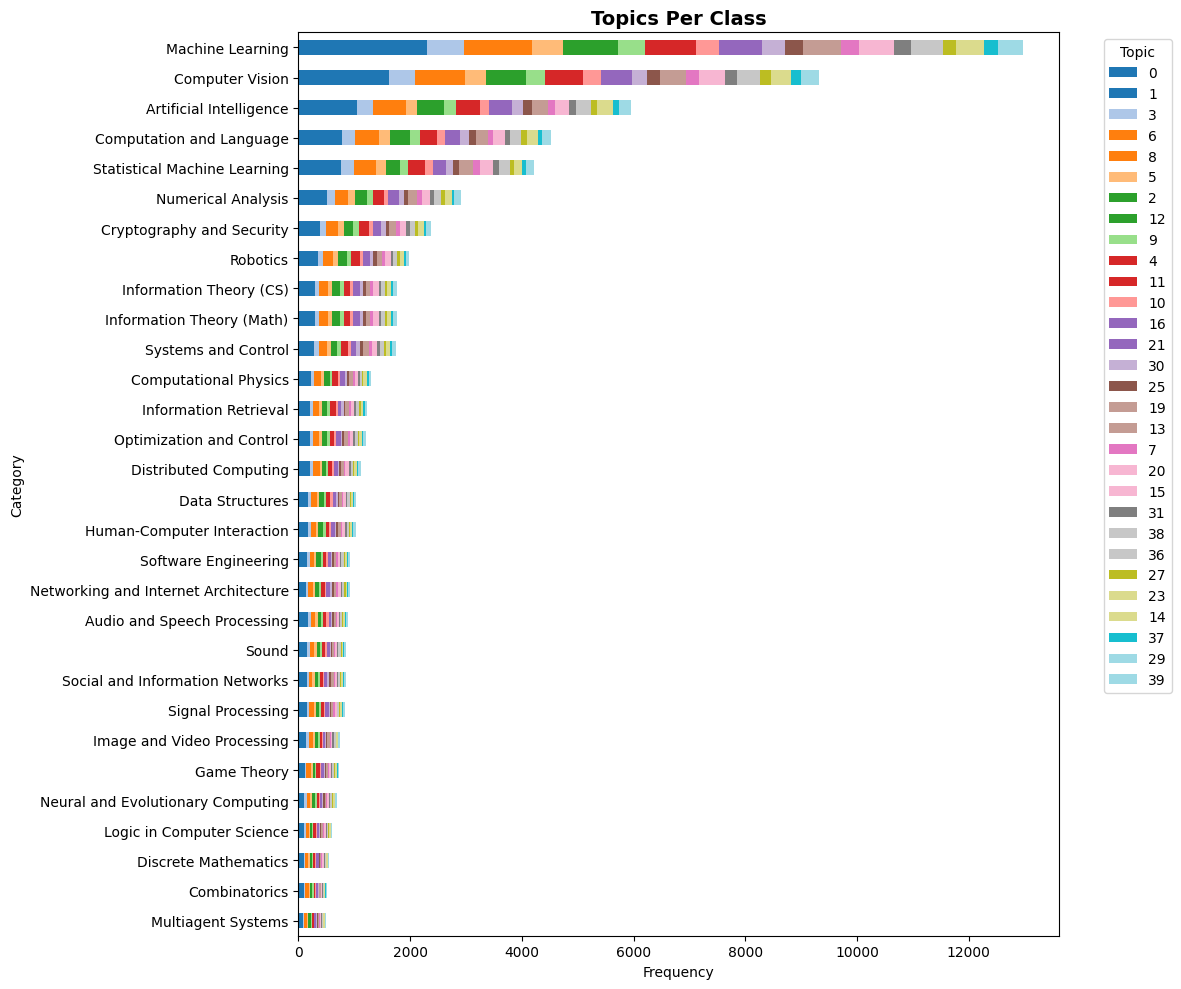

In [ ]:


# Step 1: Map raw arXiv category strings to a list of friendly names
def map_categories(cat_string):
    cats = cat_string.split()
    return [category_map.get(c, c) for c in cats]

# Step 2: Apply mapping to df_valid
df_valid["friendly_cats"] = df_valid["categories"].apply(map_categories)

# Step 3: Explode into long format and add topic column
df_exploded = df_valid.explode("friendly_cats")
df_exploded["topic"] = df_valid["topic"].repeat(df_valid["friendly_cats"].str.len()).reset_index(drop=True)

# Step 4: Group by category and topic to count how often each topic appears in each category
topic_cat_counts = df_exploded.groupby(["friendly_cats", "topic"]).size().reset_index(name="count")

# Step 5: Pivot into wide format for stacked bars
pivot_df = topic_cat_counts.pivot(index="friendly_cats", columns="topic", values="count").fillna(0)

# Step 6: Limit to top 30 categories by total count
top_30_cats = pivot_df.sum(axis=1).sort_values(ascending=False).head(30)
pivot_df = pivot_df.loc[top_30_cats.index]

# Step 7: Limit to top 30 topics only (drop others completely)
top_30_topics = pivot_df.sum().sort_values(ascending=False).head(30).index
pivot_df_reduced = pivot_df[top_30_topics]

# Step 8: Assign unique colors to each topic
import matplotlib.cm as cm
import numpy as np

distinct_colors = cm.get_cmap("tab20", 30)  # tab20 has 20, but we extract 30 distinct values by forcing it
color_dict = {topic: distinct_colors(i) for i, topic in enumerate(top_30_topics)}

# Step 9: Reorder categories by total frequency (descending, top at top of chart)
pivot_df_reduced = pivot_df_reduced.loc[pivot_df_reduced.sum(axis=1).sort_values(ascending=False).index].iloc[::-1]

# Step 10: Plot
pivot_df_reduced.plot(
    kind="barh",
    stacked=True,
    figsize=(12, 10),
    color=[color_dict[col] for col in pivot_df_reduced.columns]
)

plt.title("Topics Per Class", fontsize=14, weight="bold")
plt.xlabel("Frequency")
plt.ylabel("Category")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Lastly, let's examine the most frequently occurring research areas within our filtered arXiv dataset.

A key observation is the widespread dominance of Topic 0, characterized by broad terms like problems, tasks, time, and language. This topic likely reflects high-level framing or problem setup sections that appear in diverse research areas. Its prevalence across almost all categories suggests it may capture general machine learning discourse — such as methodological overviews, experimental setups, or system descriptions — rather than domain-specific content.

The Machine Learning category is unsurprisingly the most diverse and highest in volume. It contains strong contributions from topics like Topic 1 (adversarial attacks and defenses), Topic 6 (causal inference), Topic 23 (transformers and attention), and Topic 2 (federated learning), reflecting the breadth of subfields ML now encompasses. This heterogeneity points to the maturity of ML as a field, where specialized sub-communities now drive major portions of research.

Computer Vision and Artificial Intelligence also display considerable topical diversity, but with different dominant themes. Vision-heavy categories skew toward Topic 18 (object detection, e.g., COCO, DETR) and Topic 33 (vision transformers, ViTs), suggesting the evolution of CV from convolutional architectures to transformer-based pipelines. Meanwhile, Artificial Intelligence features broader task topics like Topic 4 (blockchains and transactions) and Topic 28 (dialogue systems), reflecting a focus on systems that mimic or support human interaction and trust.

Interestingly, Statistical Machine Learning, Computation and Language, and Numerical Analysis show a mix of classic and modern machine learning topics. For instance, Topic 25 (convex and non-convex optimization) appears in all three, demonstrating the foundational role optimization continues to play across ML and NLP tasks. These overlaps highlight how traditional mathematical concerns remain deeply embedded in today's deep learning pipelines.

Certain categories show tight topical concentration. For example, Robotics is heavily focused on Topic 15 (multi-robot planning and swarm systems) and Topic 9 (control theory), while Speech and Audio Processing (captured via Information Theory and Sound) aligns strongly with Topic 13 (ASR and acoustic modeling). These patterns confirm the task-specific nature of these subfields, where domain constraints and legacy infrastructure shape the problem space more tightly than in general-purpose categories.

Another noteworthy trend is the presence of Topic 11 (fairness and protected groups) across a surprising range of categories, from Information Retrieval to Distributed Computing. This suggests a growing emphasis on ethical considerations in ML research, even in systems-level work not traditionally associated with fairness concerns. It reflects a broader cultural and academic shift toward responsible AI, likely influenced by industry pressure and societal demands for accountability.

# Section 5: Looking into Junk Topic (-1)

### Section 5: Exploring the Content of Junk and Non-Junk Topics

To better understand the composition of the junk topic (`-1`), we filtered the dataset to isolate all documents that were assigned to this category by BERTopic. These abstracts were originally considered too generic or lacking in distinct semantic features to be clustered into a meaningful topic.

To investigate further, we applied stopword removal to the already cleaned abstracts from the junk topic. This additional cleaning step helped strip away high-frequency, low-value words that could still remain from earlier processing. By comparing the original `clean_abstract` column to the newly generated `clean_no_stop` version, we were able to examine what content—if any—remained that could hint at underlying themes or structure within the junk topic.

This step set the foundation for deeper inspection, including visualizing word distributions and potentially re-clustering these abstracts separately to recover missed subtopics.

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Filter Junk Topic (-1)
df_junktopic = df_topics[df_topics["topic"] == -1].copy()

# Apply stopword removal to cleaned abstracts
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df_junktopic["clean_no_stop"] = df_junktopic["clean_abstract"].apply(remove_stopwords)

# Preview
df_junktopic[["clean_abstract", "clean_no_stop"]].head()

clean_abstract  \
3   reliability prediction important task software...   
5   one reduce size graph without significantly al...   
6   computer vision relies labeled datasets traini...   
8   recent breakthrough paz schwartzman soda prese...   
14  study stochastic team problems static informat...   

                                        clean_no_stop  
3   reliability prediction important task software...  
5   one reduce size graph without significantly al...  
6   computer vision relies labeled datasets traini...  
8   recent breakthrough paz schwartzman soda prese...  
14  study stochastic team problems static informat...

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
docs_no_stop = df_junktopic["clean_no_stop"].tolist()

# Generate embeddings
embeddingsJunk = model.encode(docs_no_stop, show_progress_bar=True)

# Re-run BERTopic on cleaned embeddings
subtopic_model = BERTopic(language="english", verbose=True)
subtopics, probs = subtopic_model.fit_transform(docs_no_stop, embeddingsJunk)

# Add to DataFrame
df_junktopic["subtopic"] = subtopics
df_junktopic["subtopic_prob"] = probs

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5052 [00:00<?, ?it/s]

2025-04-06 21:42:39,376 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-06 21:46:34,727 - BERTopic - Dimensionality - Completed ✓
2025-04-06 21:46:34,733 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-06 21:46:54,386 - BERTopic - Cluster - Completed ✓
2025-04-06 21:46:54,430 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-06 21:47:10,844 - BERTopic - Representation - Completed ✓


In [ ]:
df_junktopic.head()

id                                              title  \
3   1503.00102  CARP: Context-Aware Reliability Prediction of ...   
5   1808.10650   Graph reduction with spectral and cut guarantees   
6   1812.11901  Large-Scale Object Detection of Images from Ne...   
8   1701.03730  Simplified and Space-Optimal Semi-Streaming fo...   
14  1603.03160  Near-Optimality of Linear Strategies for Stati...   

                                             abstract  \
3   Reliability prediction is an important task in...   
5   Can one reduce the size of a graph without sig...   
6   Computer vision relies on labeled datasets for...   
8   In a recent breakthrough, Paz and Schwartzman ...   
14  We study stochastic team problems with static ...   

                     categories  \
3                         cs.SE   
5                 cs.DS stat.ML   
6                         cs.CV   
8                         cs.DS   
14  math.OC cs.GT cs.IT math.IT   

                                              authors        date  year  \
3   [['Zhu', 'Jieming', ''], ['He', 'Pinjia', ''],...  2019-01-01  2019   
5                         [['Loukas', 'Andreas', '']]  2019-01-01  2019   
6   [['Tung', 'Caleb', ''], ['Kelleher', 'Matthew ...  2019-01-01  2019   
8   [['Ghaffari', 'Mohsen', ''], ['Wajc', 'David',...  2019-01-01  2019   
14                     [['Kulkarni', 'Ankur A.', '']]  2019-01-01  2019   

                                       clean_abstract  topic  probability  \
3   reliability prediction important task software...     -1          0.0   
5   one reduce size graph without significantly al...     -1          0.0   
6   computer vision relies labeled datasets traini...     -1          0.0   
8   recent breakthrough paz schwartzman soda prese...     -1          0.0   
14  study stochastic team problems static informat...     -1          0.0   

                                        clean_no_stop  subtopic  subtopic_prob  
3   reliability prediction important task software...        -1            0.0  
5   one reduce size graph without significantly al...         1            1.0  
6   computer vision relies labeled datasets traini...        -1            0.0  
8   recent breakthrough paz schwartzman soda prese...         5            1.0  
14  study stochastic team problems static informat...        -1            0.0

In [ ]:
df_junktopic['subtopic'].nunique()

801

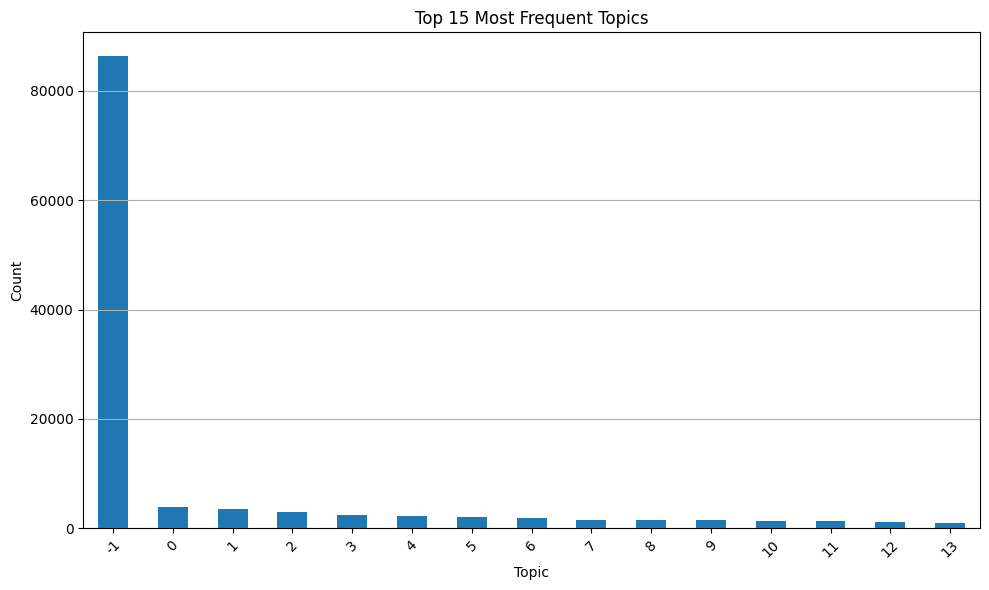

In [ ]:
# Recount topic frequencies after removing junk topic
top_counts = df_junktopic["subtopic"].value_counts().head(15)

# Plot
plt.figure(figsize=(10,6))
top_counts.plot(kind='bar')
plt.title("Top 15 Most Frequent Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


After identifying that a large portion of our dataset (~160,000 documents) had been assigned to the junk topic (`-1`), we sought to investigate whether this group contained hidden structure that BERTopic had initially failed to recognize. To do this, we first applied stopword removal to the cleaned abstracts within the junk topic, reducing linguistic noise and improving the semantic clarity of the text.

We then re-encoded the stopword-free abstracts using the same `all-MiniLM-L6-v2` SentenceTransformer model and re-ran BERTopic on these new embeddings. This allowed us to rediscover latent patterns within the previously unclustered documents. As shown in the new bar chart, the junk topic has now been decomposed into several distinct subtopics, with many clusters having a few thousand documents—indicating successful recovery of meaningful themes that were missed in the initial pass.

This highlights the value of post-processing and re-clustering in topic modeling workflows, especially when dealing with large, noisy, or generic text corpora.

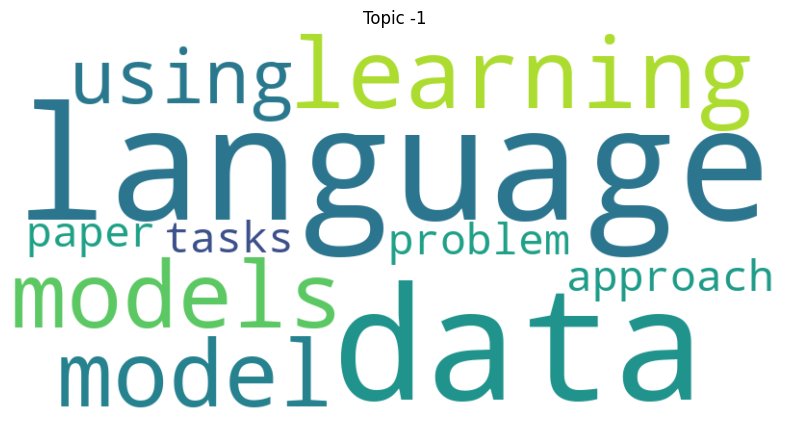

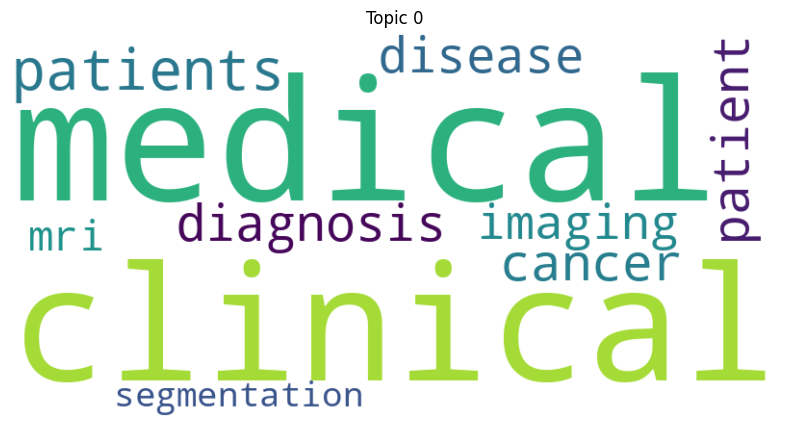

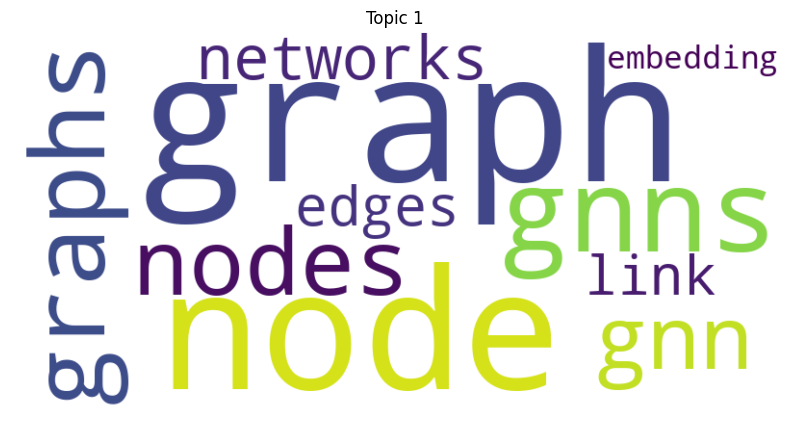

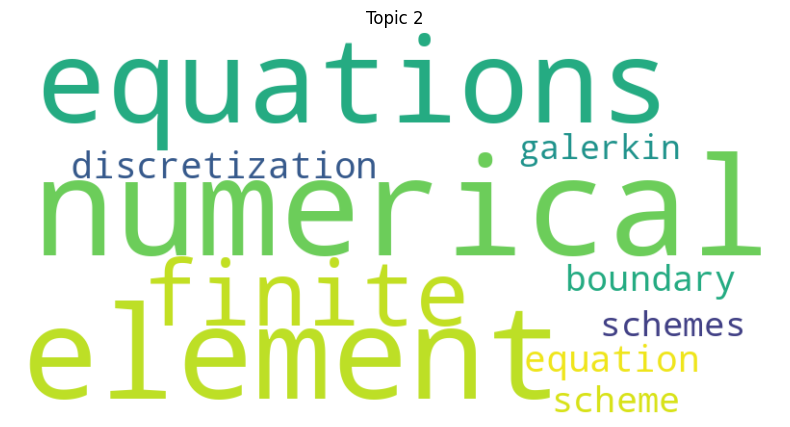

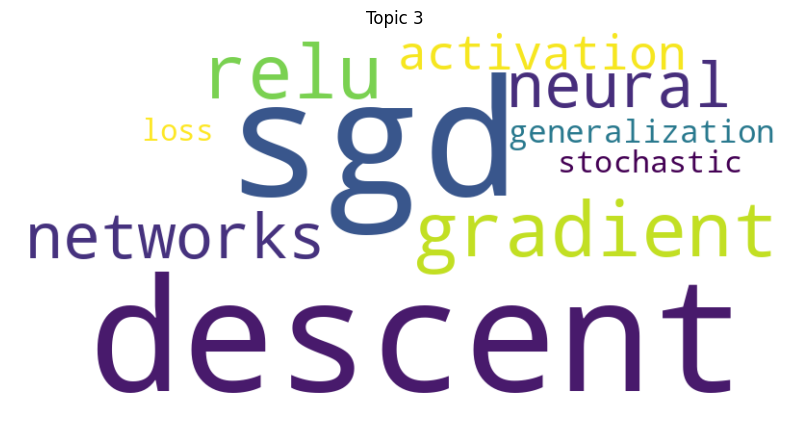

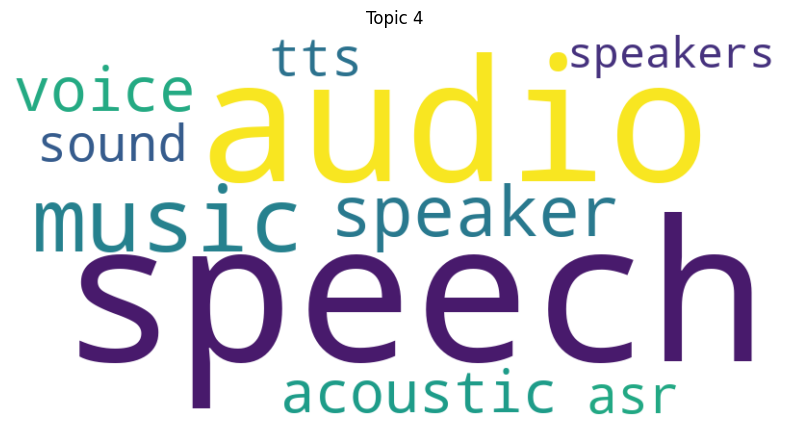

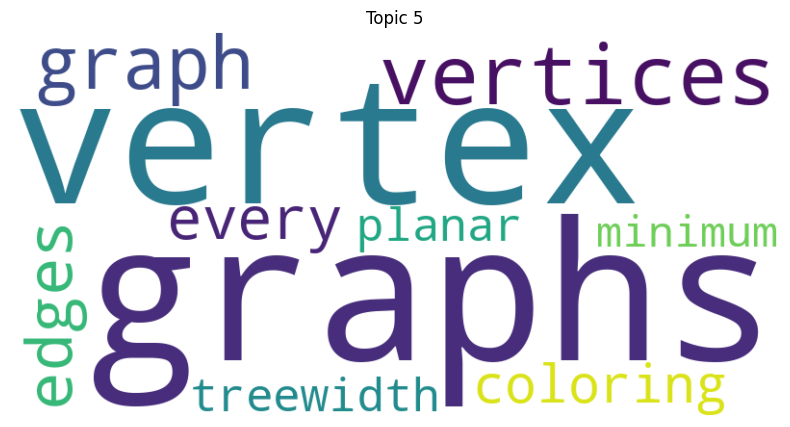

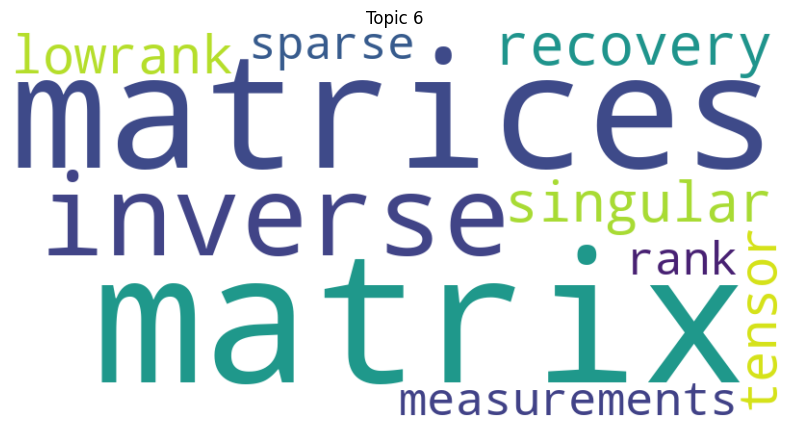

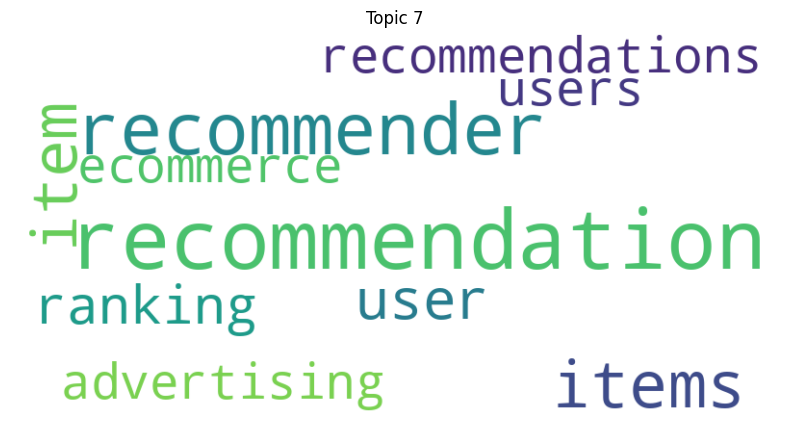

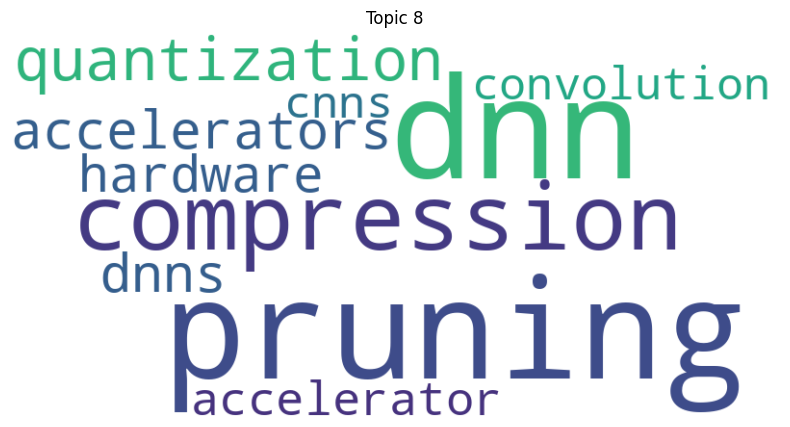

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the topic information from the fitted BERTopic model
subtopic_info = subtopic_model.get_topic_info()

# Generate word clouds for a subset of topics (e.g., top 10)
top_n = 10
top_topics = subtopic_info.head(top_n)["Topic"].tolist()

# Loop through and generate word clouds
for topic in top_topics:
    words = subtopic_model.get_topic(topic)
    if words:
        word_freq = {word: weight for word, weight in words}

        wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic}")
        plt.show()

In [ ]:
subtopic_info.head()

Topic  Count                                  Name  \
0     -1  86362      -1_language_data_learning_models   
1      0   3840    0_medical_clinical_patients_cancer   
2      1   3438              1_graph_node_gnns_graphs   
3      2   2916  2_numerical_element_equations_finite   
4      3   2400           3_sgd_descent_gradient_relu   

                                      Representation  \
0  [language, data, learning, models, model, usin...   
1  [medical, clinical, patients, cancer, diagnosi...   
2  [graph, node, gnns, graphs, nodes, gnn, networ...   
3  [numerical, element, equations, finite, discre...   
4  [sgd, descent, gradient, relu, neural, network...   

                                 Representative_Docs  
0  [paper deals problem autonomous navigation mob...  
1  [many practical applications deep neural netwo...  
2  [graph neural networks gnns attracted increasi...  
3  [propose analyze computationally new fictitiou...  
4  [analyze convergence averaged stochastic gradi...

In [ ]:
# Filter for topic -1 within junk topics
df_junktopic1 = df_junktopic[df_junktopic["subtopic"] == -1]

# Show a few samples (with category, title, and abstract)
df_junktopic1[["categories", "title", "abstract"]].sample(5, random_state=42)

categories  \
202816                  cs.LO   
55102                   cs.AR   
111925  math.ST cs.CC stat.TH   
285130      cs.RO cs.AI cs.LG   
189965            cs.LG cs.AI   

                                                    title  \
202816  A Formal Specification of Operating System bas...   
55102   Report on power, thermal and reliability predi...   
111925  Incidence geometry in the projective plane via...   
285130  Benchmarking Potential Based Rewards for Learn...   
189965            Skill-based Meta-Reinforcement Learning   

                                                 abstract  
202816  In this paper, by using the formal language \e...  
55102   By combining Three Dimensional Integrated Circ...  
111925  We present an encoding of a polynomial system ...  
285130  The main challenge in developing effective rei...  
189965  While deep reinforcement learning methods have...

Despite our re-clustering efforts on the original junk topic, we see that a large portion—over 80,000 documents—still fell into a new subtopic labeled -1. This suggests that BERTopic once again struggled to assign these documents confidently. The word cloud for this subtopic includes broad, generic terms like "data," "language," "models," "learning," and "tasks", which are common across many machine learning papers but don't provide enough specific context for meaningful clustering.

This implies that these documents are either:

Overly general, lacking distinguishing domain-specific language,
Or semantically ambiguous, discussing common methodologies without unique contributions.
So while re-clustering recovered several subtopics, this -1 group likely contains true residual noise or abstracts that are simply too vague for confident classification.

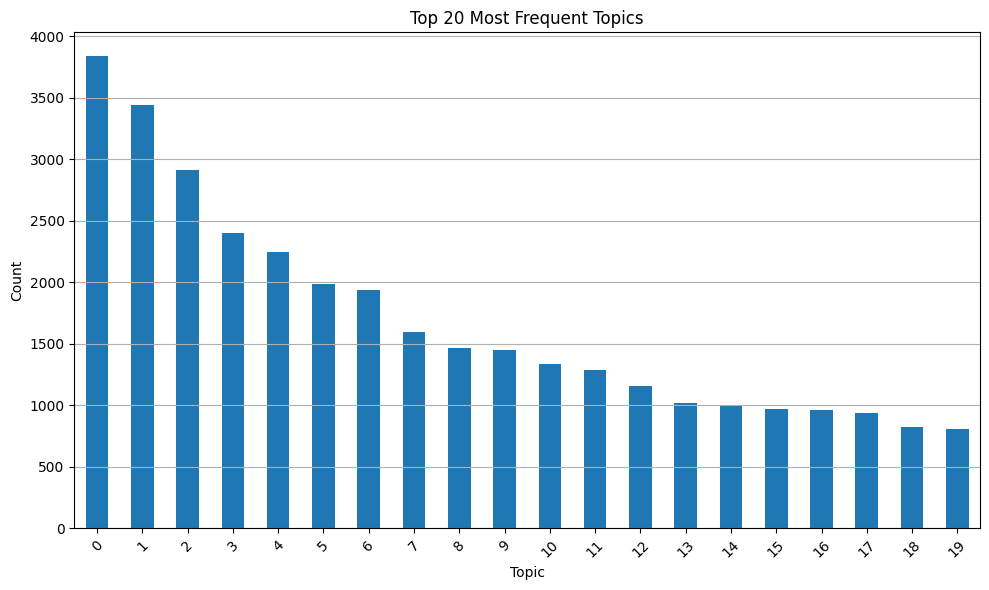

In [ ]:
# Remove subtopic -1 from the re-clustered junk topic DataFrame
df_junktopic_cleaned = df_junktopic[df_junktopic["subtopic"] != -1].copy()


# Recount topic frequencies after removing junk topic
top_counts = df_junktopic_cleaned["subtopic"].value_counts().head(20)

# Plot
plt.figure(figsize=(10,6))
top_counts.plot(kind='bar')
plt.title("Top 20 Most Frequent Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

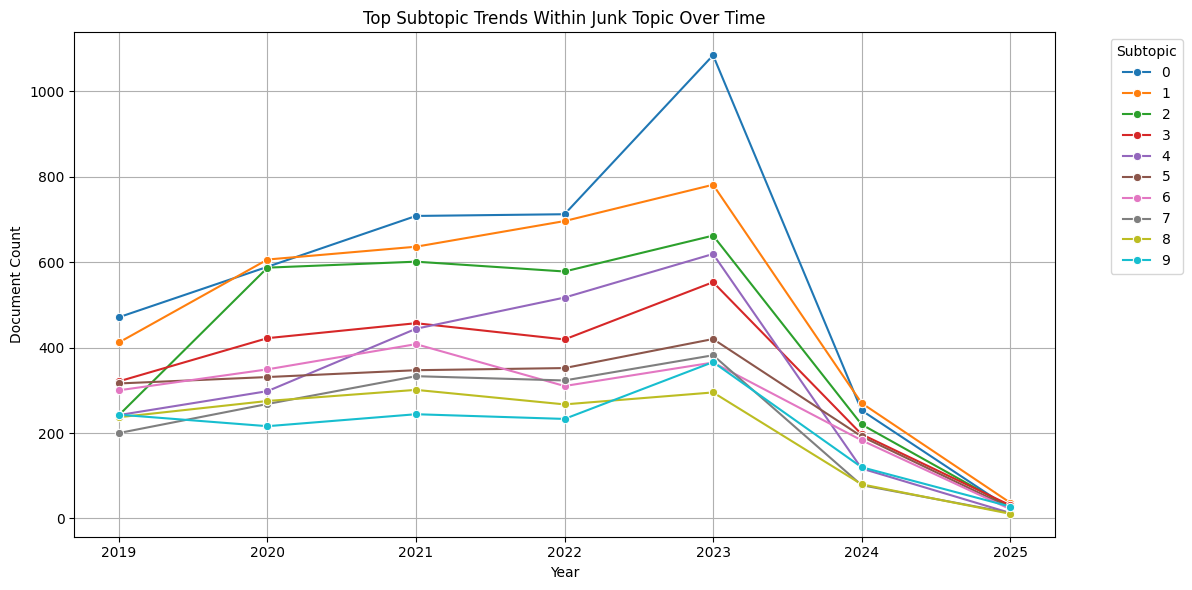

In [ ]:
# Optional: focus on top 10 subtopics for clarity
top_subtopics = (
    df_junktopic_cleaned["subtopic"]
    .value_counts()
    .head(10)
    .index
    .tolist()
)
trend_data_filtered = df_junktopic_cleaned[df_junktopic_cleaned["subtopic"].isin(top_subtopics)]
trend_data = trend_data_filtered.groupby(["year", "subtopic"]).size().reset_index(name="count")

# Set color palette with enough distinction
palette = sns.color_palette("tab10", n_colors=len(top_subtopics))

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x="year", y="count", hue="subtopic", marker="o", palette=palette)

plt.title("Top Subtopic Trends Within Junk Topic Over Time")
plt.xlabel("Year")
plt.ylabel("Document Count")
plt.legend(title="Subtopic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Show interactive barchart for subtopics within Topic 6
subtopic_model.visualize_barchart(top_n_topics=9, height=700)

The subcluster word score visualizations for Topic -1—the catch-all or “junk” topic—reveal why such a large proportion of documents (initially over 160,000) evaded classification in the first round of topic modeling. While these documents were not noise in the traditional sense, many lacked the strong semantic cohesion needed for BERT-based clustering to confidently assign them to one of the primary topics. This speaks to a broader limitation in embedding-based models: without highly distinctive or domain-anchored language, otherwise valid documents may end up sidelined due to ambiguity or cross-disciplinary overlap.

Several emergent subtopics from this secondary modeling effort illustrate this clearly. Topic 1, which focuses on biomedical research with terms like “medical,” “clinical,” “patients,” and “cancer,” reflects a field with its own well-developed vocabulary. However, many biomedical papers often involve machine learning applications or statistical methods, making them inherently cross-domain. This hybridity can dilute their embedding signal and prevent the model from clustering them cleanly alongside more narrowly focused groups.

Similarly, Topic 2—anchored around graph theory terms like “graphs,” “vertices,” and “edges”—points to foundational work in discrete mathematics. These papers may have lacked an applied context (like GNNs or social networks), which normally helps define a document’s topical boundaries. As a result, their core terminology, while academically coherent, appears too abstract or too general for the model to confidently cluster them.

Topic 3 presents a particularly interesting case. It contains strong indicators of reinforcement learning, including “rl,” “policy,” and “mdps.” This is a well-established and easily distinguishable domain, so its presence in the unclassified pool suggests another issue: perhaps the abstracts were too high-level, lacked technical depth, or included terminology that overlapped with neighboring areas like multi-agent systems or online optimization. BERT-based models, while powerful, sometimes struggle to separate semantically similar yet contextually different subfields, especially when abstracts are short or sparsely descriptive.

Finally, Topic 6—focused on “speech,” “audio,” and “music”—likely spans multiple application areas such as speech recognition, audio synthesis, or even music information retrieval. These overlapping signals, while indicative of a coherent theme, may have caused enough diffusion in the embedding space to prevent confident assignment.

Together, these examples illustrate a broader insight: many papers that fell into Topic -1 weren’t poorly written or off-topic, but rather represented “gray area” documents—those that are interdisciplinary, abstract, or methodologically focused. This reveals a limitation in BERT-based topic modeling where high generality, cross-domain language, or insufficient context prevents successful clustering. It underscores the need for refined modeling strategies (e.g. hierarchical clustering, hybrid semantic-taxonomic models) when dealing with large, heterogeneous corpora.

In [ ]:
subtopic_model.visualize_term_rank()

In [ ]:
subtopic_model.visualize_term_rank(log_scale=True)


In [ ]:
subtopic_model.visualize_topics(top_n_topics=50)

In [ ]:
subtopic_model.visualize_hierarchy(top_n_topics=50, width=1000)

# 1. Term Score Decline per Topic (Linear & Log Scale)
The term score decline plots show how c-TF-IDF scores fall off as we move from the highest-ranked to lower-ranked terms within each topic. These plots reveal that many topics in the junk cluster have shallow gradients, with even the top-ranked terms receiving relatively low scores compared to what we typically see in tightly clustered topics. On the log scale, the uniformity of the decline becomes even clearer: most lines converge tightly, indicating a lack of sharp distinction between top and bottom-ranked words across topics.

This flatness implies that the papers grouped into junk topics do not share a small set of dominant, high-signal keywords—unlike well-formed topics where 3–5 terms often capture the bulk of semantic meaning. Instead, they are characterized by broad or diffuse vocabulary usage, making it harder for c-TF-IDF weighting to confidently assign them to unique themes. This lack of lexical cohesion is likely a key driver for why these documents ended up unclassified in the original model.

# 2. Intertopic Distance Map
The intertopic distance map (likely generated via UMAP) illustrates how far apart or clustered the different topic centroids are in embedding space. In this case, most clusters are relatively tight and well-separated, suggesting clear distinctions between meaningful topics. However, the junk topic is either missing from this map or appears as a diffused, less defined region (as is typical with Topic -1), which likely reflects its semantic ambiguity and internal inconsistency.

This separation (or lack thereof) further indicates that the papers grouped into Topic -1 do not share enough latent semantic coherence to form a dense cluster, thus appearing as outliers or drifting between topic boundaries. In embedding space, they may lie on the edges or in-between major topics, lacking the gravitational pull to any one.

# 3. Hierarchical Clustering Dendrogram
The dendrogram offers a tree-based view of semantic similarity between topics. Interestingly, several of the junk-derived topics from reclassification do appear here, such as those related to “pose,” “speech,” or “emotion,” but they tend to cluster with broader or loosely-defined branches. This could indicate that while these fragments contain minor substructure, they may be thematically too shallow or noisy to stand alone in the original model.

Additionally, some junk clusters align with topics like "GANs," "code," or "graphs," which suggests they are borderline or adjacent to core clusters but not dense enough to form dominant themes. This “near-topic” quality may explain why the BERT model originally hesitated to classify them—especially if the textual patterns were either too general or lacked strong contextual embeddings.

# Synthesis
Across all four visuals, a clear pattern emerges: the documents grouped into Topic -1 are characterized by broad, low-density term usage, limited lexical uniqueness, and semantic ambiguity in vector space. These factors collectively challenge the BERT-based topic model’s ability to assign them with confidence. This underscores a broader limitation of transformer-based models, which—despite their contextual strength—still rely heavily on clustering density and term significance to distinguish topics. In absence of clear anchors (like domain-specific jargon or recurring phrases), the model defaults to classifying such documents as miscellaneous or “junk,” even if they touch on legitimate but diffuse subdomains.